# sapphire inference with Zgas on MAnGA data

In [3]:
import jax
import jax.numpy as jnp
import flax.linen as nn

import numpy as np

import torch
from tqdm import tqdm
import optax

import tensorflow_probability.substrates.jax as tfp

import matplotlib.pyplot as plt
import cloudpickle as pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

# load manga data

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join, hstack
from astropy.io import fits

import seaborn as sns

tread = Table.read('manga_merged_viraj.fits',format='fits')

print(len(tread), len(tread[tread['MW_Z_3ARCSEC'] != -9999]))
tread = tread[tread['MW_Z_3ARCSEC'] != -9999]

print(len(tread), len(tread[(tread['log_Mass']>9) & (tread['log_Mass']<10.7)]))
tread = tread[(tread['log_Mass']>9) & (tread['log_Mass']<10.7)]

print(len(tread), len(tread[np.log10(10**tread['log_SFR_Ha'] / 10**tread['log_Mass']) > -11]))
tread = tread[np.log10(10**tread['log_SFR_Ha'] / 10**tread['log_Mass']) > -11]

tread = tread[tread['e_log_SFR_Ha']<1]

# introduce log Zgas
tread['log_Zgas'] = np.log10(10**(tread['OH_R23_cen']-8.69))
#tread = tread[(10**tread['log_Zgas']>(6)) & (10**tread['log_Zgas']<(10))]
tread = tread[(tread['log_Zgas']>-1) & (tread['log_Zgas']<0.25)] 

# remove ridiculously large error
tread = tread[(10**tread['e_OH_R23_cen']<10)]

names = [name for name in tread.colnames if len(tread[name].shape) <= 1] # from error message without this line
df_final = tread[names].to_pandas()

df_final = df_final[['log_Mass','log_SFR_Ha','log_Zgas', 'e_log_Mass', 'e_log_SFR_Ha', 'e_OH_R23_cen' ]]

df_final = df_final.dropna()

# save manga errors to use in training
np.save("manga_errors_mass_sfr_zgas",
    np.array(df_final[['e_log_Mass', 'e_log_SFR_Ha', 'e_OH_R23_cen']])
)


# transform the sigmas here and send to numpy array
data_target = np.array(df_final)
#data_target[..., 3:] = transform_sigmas(data_target[..., 3:], jax=False)
data_target[..., 3:] = (data_target[..., 3:])

data_target = jnp.array(data_target)

data_target.shape[0]

9927 9619
9619 4979
4979 3466


2024-11-13 13:48:49.019201: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.0 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


3345

# network stuff in Jax

In [5]:
#@title network stuff in Jax  <font color='lightblue'>[run me]</font>


from tqdm import tqdm
import math

from typing import Sequence, Any, Callable
Array = Any

import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn

@jax.jit
def smooth_leaky(x: Array) -> Array:
  r"""Smooth Leaky rectified linear unit activation function.

  Computes the element-wise function:

  .. math::
    \mathrm{smooth\_leaky}(x) = \begin{cases}
      x, & x \leq -1\\
      - |x|^3/3, & -1 \leq x < 1\\
      3x & x > 1
    \end{cases}

  Args:
    x : input array
  """
  return jnp.where(x < -1, x, jnp.where((x < 1), ((-(jnp.abs(x)**3) / 3) + x*(x+2) + (1/3)), 3*x)) / 3.5



def fill_triangular(x):
    m = x.shape[0] # should be n * (n+1) / 2
    # solve for n
    n = int(math.sqrt((0.25 + 2 * m)) - 0.5)
    idx = jnp.array(m - (n**2 - m))
    x_tail = x[idx:]

    return jnp.concatenate([x_tail, jnp.flip(x, [0])], 0).reshape(n, n)


def fill_diagonal(a, val):
  assert a.ndim >= 2
  i, j = jnp.diag_indices(min(a.shape[-2:]))
  return a.at[..., i, j].set(val)


def construct_fisher_matrix_single(outputs):
    Q = tfp.math.fill_triangular(outputs)
    middle = jnp.diag(jnp.triu(Q) - nn.softplus(jnp.triu(Q)))
    padding = jnp.zeros(Q.shape)
    L = Q - fill_diagonal(padding, middle)

    return jnp.einsum('...ij,...jk->...ik', L, jnp.transpose(L, (1, 0)))


class MLP(nn.Module):
  features: Sequence[int]
  act: Callable = nn.elu

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = self.act(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x


class FishnetNetwork(nn.Module):
    hidden_channels: list
    n_p: int
    act: Callable = nn.swish

    def setup(self):

        fdim = self.n_p + ((self.n_p * (self.n_p + 1)) // 2)
        fisherdim = ((self.n_p * (self.n_p + 1)) // 2)
        self.scorenet = MLP(self.hidden_channels + (self.n_p,), act=self.act)
        self.fishernet = MLP(self.hidden_channels + (fisherdim,), act=self.act)
        self.outnet = nn.Dense(self.n_p)

    def __call__(self, x, mask=None):

        # cut down mass value
        x = x.at[:, 0].set(x[:, 0] / 10.)

        # get score embedding and then sum
        score = self.scorenet(x)
        # get fisher cholesky factors
        fisher = self.fishernet(x)

        if mask is not None:
            score = jnp.where(mask, score, 0.0)
            #fisher = jnp.where(mask, fisher, 0.0)

        score = score.sum(0)

        # get the fisher matrix and add prior term
        fisher = jax.vmap(construct_fisher_matrix_single)(fisher)
        if mask is not None:
            fisher = jnp.where(mask[..., jnp.newaxis], fisher, 0.0)
        fisher = jnp.sum(fisher, axis=0) + jnp.eye(self.n_p)
        

        # get MLE
        x = jnp.einsum('...jk,...k->...j', jnp.linalg.inv(fisher), score)

        #x = self.outnet(x)

        return x, score, fisher

# do a regression scheme
load in Viraj's data and standardize for the network. we'll pad the input sets with zeros, up to $N_{\rm halo}=120$. Parameter combinations that result in fewer halos for the population will be automatically downweighted in the inference. The data needed for the rest of this notebook can be found here via a public [Google Drive link](https://drive.google.com/drive/folders/1UOuwPK3WcP3YlrEsr5SBzSyZXCmg7wVh?usp=sharing). (Copy this data into your drive and mount Google Drive to point the notebook to this folder if the below cell doesn't work for you).

In [6]:
n_d = 1_000 # number of halos per parameter value
num_features = 5
n_params = 4

num_sims = 40_000

In [7]:
def load_dataset(npz_fname, num_analyse=10000, return_scaler=False):
    """
    data_stacks has shape (Nrealizations, Nhalos per realization, Nfeatures per halo)
    order of features:
    logmstar/msun, logmism/msun, logmcgm/msun, logecgm/erg, logmzstar/msun, logmzism/msun, logmzcgm/msun  [all base-10 log]
    'Zcgm','Zism','n0','T0','Mvir','Mdot_wind','Mdot_sfr','Mdot_cool'
    
    theta_stacks has shape (Nrealizations, Nparams)
    order of parameters = etaM_A, etaM_alpha, etaE_A, etaE_alpha (can vary more parameters in future)
    I used log-uniform priors for our "pseudo" latin-hypercube
    lh_etaM_A = jax.random.uniform(jax.random.key(1),shape=(Nrealizations,),minval=-2,maxval=2) # this is log10
    lh_etaM_alpha = jax.random.uniform(jax.random.key(2),shape=(Nrealizations,),minval=-2,maxval=0)
    lh_etaE_A = jax.random.uniform(jax.random.key(3),shape=(Nrealizations,),minval=-2,maxval=0) # this is log10
    lh_etaE_alpha = jax.random.uniform(jax.random.key(4),shape=(Nrealizations,),minval=-2,maxval=0)
    
    etaM_A, etaM_alpha, etaE_A, etaE_alpha, tdep_A, tdep_alpha, tdep_beta, etaZ_A, etaZ_alpha . the tdep parameters are for the power law dependence of SF timescale on halo mass (just like the eta's) multiplied by (1+z)^beta to also account for redshift dependence as observed. the etaZ parameters are similar to etaM and etaE but control how much SN metals get ejected from galaxies -- I suspect Zstar will be quite sensitive to this
    I used similar priors (log-uniform for normalizations _A and uniform for slopes _alpha and _beta):
    lh_tdep_A = jax.random.uniform(jax.random.key(7),shape=(Nrealizations,),minval=-2,maxval=1) # this is log10
    lh_tdep_alpha0 = jax.random.uniform(jax.random.key(8),shape=(Nrealizations,),minval=-4,maxval=0)
    lh_tdep_beta = jax.random.uniform(jax.random.key(9),shape=(Nrealizations,),minval=-2,maxval=0)
    lh_etaZ_A = jax.random.uniform(jax.random.key(5),shape=(Nrealizations,),minval=-2,maxval=0) # this is log10
    lh_etaZ_alpha = jax.random.uniform(jax.random.key(6),shape=(Nrealizations,),minval=-2,maxval=0)
    """
    npz_file = jnp.load(npz_fname)

    
    data_stacks = jnp.asarray(npz_file['data_stacks'])
    theta_stacks = jnp.asarray(npz_file['theta_stacks'])
    
    ### example: re-create data_ and theta_ arrays for sapphire_regression_demo.ipynb (which uses only Mstar/Mvir)
    
    # n_d = 1000 # number of halos per parameter value
    # num_features = 5
    # n_params = 9
    num_sims = len(data_stacks)
    
    
    # make sure to log10 the first theta dim
    theta_stacks = theta_stacks.at[:, 0].set(jnp.log10(theta_stacks[:, 0]))
    theta_stacks = theta_stacks.at[:, 2].set(jnp.log10(theta_stacks[:, 2]))
    
    
    # cut down to 5000 for training
    
    ### theta_stacks is already has the required format/shape of (Nrealizations, 4) -- see above
    
    data_full = data_stacks[:num_analyse]
    theta_full = theta_stacks[:num_analyse, :n_params]
    
    
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0.0, 1.0))
    theta_full = scaler.fit_transform(theta_full)
    
    del data_stacks

    if return_scaler:
        return data_full, theta_full, scaler

    return data_full, theta_full

In [8]:
fname_train = "/data101/makinen/sapphire/jax_tng_lucas_100K_1000_9params_15features_20241107_batch0.npz"
data_full, theta_full, scaler = load_dataset(fname_train, num_analyse=40000, return_scaler=True)

In [9]:
data_full.shape, theta_full.shape

((40000, 1000, 15), (40000, 4))

In [10]:
# design a noise simulator function that takes raw values, adds noise, and then outputs features
import jax.random as jr
from functools import partial

num_features_input = 3 + 3 # this is how many get fed to the network 3vars, 3sigs


def transform_sigmas(sigmas, jax=True):
    if jax:
        lg = jnp.log
    else:
        lg = np.log
    return lg((1./(sigmas + 1e-4))) / 2.5

#@jax.jit
def log_uniform(r, log_min_val, log_max_val):
    """log-uniform prior
      given point sampled from unif(0, 1)
      return point sampled on a uniform log scale from min_val to max_val
      """
    #log_min_val = np.log10(min_val)
    #log_max_val = np.log10(max_val)
    point = 10.0 ** (log_min_val + r * (log_max_val - log_min_val))
    return point

def log_uniform(key, shape, minval, maxval):
    return jnp.exp(jax.random.uniform(key, shape=shape, minval=jnp.log10(minval), maxval=jnp.log10(maxval)))

# LOAD MANGA SIGMAS FOR RANDOM DRAWS
manga_sigmas = jnp.load("manga_errors_mass_sfr_zgas.npy")

# WANT: Mstar, SFR, Zstar
# 0, -2, 4
@partial(jax.jit, static_argnums=(2,3))
def noise_simulator(key, data, use_manga_sigmas=True, 
                           cut=None,
                           manga_sigmas=manga_sigmas):
  """noise simulator. takes in data of shape (n_gal, 15)
     returns: noisy realisation of network inputs """


  # output container
  data_ = jnp.zeros((n_d, num_features_input))

  # make sure to log10 the features that need doing
  data = data.at[:, 11].set(jnp.log10(data[:, 11])) # Mvir
  data = data.at[:, 10].set(jnp.log10(data[:, 10])) # T0
  data = data.at[:, 9].set(jnp.log10(data[:, 9]))   # n0
  data = data.at[:, -2].set(jnp.log10(data[:, -2]))  # SFR

  # now vary the noise amplitude to marginalise out
  key,rng = jr.split(key)


  # finally, put into NN input format
  
  # log10(mstar)
  data_ = data_.at[:, 0].set(data[:,0]) # Mstar


  # log10 SFR
  #data_ = data_.at[:, 1].set(data[:, -2]) # SFR
  data_ = data_.at[:, 1].set(data[:, -2])

  # log10 Zstar stuff
  #data_ = data_.at[:, 2].set(jnp.log10(10**data[:,4] / 10**data[:,0] / 0.02))

  # log10 Zgas stuff
  #data_ = data_.at[:, 2].set(jnp.log10(data[:,8]/0.02))
  data_ = data_.at[:, 2].set(jnp.log10(10**data[:,4]/10**data[:,1]/0.02))

  # ADD NOISE HERE
  # draw sigmas
  key1,key2,key3 = jr.split(rng, num=3)

  if not use_manga_sigmas:  
      sigma_m = jr.uniform(key1, shape=(n_d,1), minval=0.03, maxval=1.25)
      sigma_sfr = jr.uniform(key2, shape=(n_d,1), minval=0.025, maxval=1.0)
      #sigma_z = jnp.abs((jr.normal(key3, shape=(n_d,)) * 0.5) * slope * jnp.abs(data_[:, 2]))
      sigma_z = jr.uniform(key3, shape=(n_d,1), minval=0.01, maxval=1.5)

      # fancier noise model for Z sigma
      #slope = jr.uniform(key3, shape=(1,), minval=0.5, maxval=2.0)
      #sigma_z = jnp.abs((jr.uniform(key3, shape=(n_d,), minval=0.025, maxval=1.5)) * 1.5 * jnp.abs(data_[:, 2]))
      #sigma_z = sigma_z[:, jnp.newaxis]
      #sigma_z2 = jr.uniform(key3, shape=(n_d//2,1), minval=0.025, maxval=1.5)
      #sigma_z = jnp.concatenate([sigma_z[:n_d//2], sigma_z2], 0)
    
      # generate noise and add to data
      sigmas = jnp.concatenate([sigma_m, sigma_sfr, sigma_z], -1)


  # alternatively, draw random sigmas (with some noise) from the manga catalogue
  else:
      idx = jr.choice(key1, jnp.arange(manga_sigmas.shape[0]), shape=(n_d,), replace=True)
      sigmas_manga = manga_sigmas[idx] + (jr.normal(key2, shape=(n_d,3)) * 1e-5)

      # slope adjustment for Z
      #slope = jr.uniform(key3, shape=(1,), minval=0.5, maxval=1.5)
      #sigmas = sigmas.at[:, -1].set(sigmas[:, -1] * slope * jnp.abs(data_[:, 2]) + (jr.normal(key3, shape=(n_d,)) * 0.1))
      sigmas_manga = jnp.abs(sigmas_manga) # just in case we go negative

  # intrinsic spread
  sigma_m = log_uniform(key1, shape=(1,), minval=10**-5.0, maxval=10**2.0)
  sigma_sfr = log_uniform(key2, shape=(1,), minval=10**-5.0, maxval=10**2.0)
  sigma_z = log_uniform(key3, shape=(1,), minval=10**-5.0, maxval=10**2.0)
    
  sigmas = jnp.concatenate([sigma_m, sigma_sfr, sigma_z], -1)
  sigmas = jnp.abs(sigmas)

  print(sigmas.shape)

  # add another layer of noise to latents for intrinsic spread
  key,rng = jr.split(key)
  noise =  jr.normal(rng, shape=(n_d,3)) * sigmas # 0.1
  data_ = data_.at[:, :3].set(data_[:, :3] + noise)
    
  # now do observational noise
  key,rng = jr.split(key)
  noise =  jr.normal(key, shape=(n_d,3)) * sigmas_manga
  #print('noise', sigmas.shape)
  data_ = data_.at[:, :3].set(data_[:, :3] + noise)

  
  # put into the data vector
  data_ = data_.at[:, 3:].set((sigmas_manga))
 
  # data[:, 4] --> massive uncertainty
  
  # match the MANGA data cuts
  # tread = tread[(tread['log_Mass']>9) & (tread['log_Mass']<10.7)]
  # tread[(tread['log_Zgas']>-1) & (tread['log_Zgas']<0.25)] 
    
  mask = (data_[:, 0] > 9) & (data_[:, 0] < 10.7) & ((10**data_[:, 1] / 10**data_[:, 0]) > -11) #& ((data[:, 2] > -1) & (data[:, 2] < 0.25))

  return data_, mask[:, jnp.newaxis], sigmas

In [11]:
key = jr.PRNGKey(454)
num = 10
footest,_,sgs = jax.vmap(noise_simulator)(jr.split(key, num), data_full[:num])

(3,)


In [12]:
manga_sigmas.shape

(3345, 3)

(array([2.598e+03, 5.230e+02, 1.060e+02, 5.900e+01, 3.200e+01, 1.400e+01,
        7.000e+00, 2.000e+00, 2.000e+00, 2.000e+00]),
 array([0.00113832, 0.09873168, 0.19632505, 0.2939184 , 0.39151177,
        0.48910514, 0.58669847, 0.68429184, 0.78188521, 0.87947857,
        0.97707194]),
 <BarContainer object of 10 artists>)

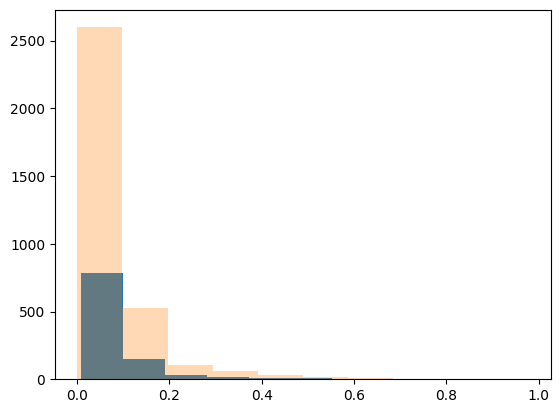

In [14]:
plt.hist(footest[0, :, -1])
#plt.hist(footest2[0, :, -1])

#plt.hist(footest[0, :, -2 ])
#plt.hist(footest[0, :, -3])

plt.hist(data_target[..., -1], alpha=0.3, density=False)
#plt.hist(footest[0, :, -4])
#plt.hist(footest[0, :, -5])

In [15]:
manga_sigmas[:, -1].max()

Array(0.97707194, dtype=float32)

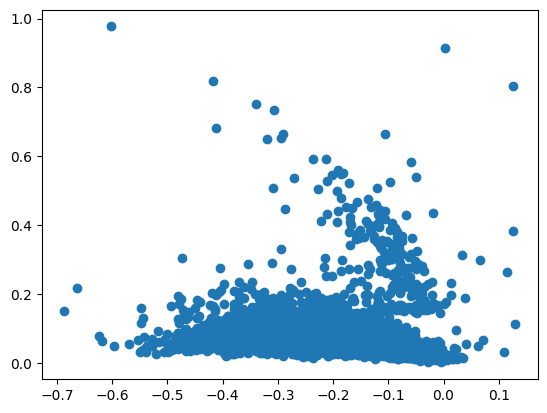

In [16]:
plt.scatter(data_target[:, 2], manga_sigmas[:, -1])

In [17]:
fooidx = 8

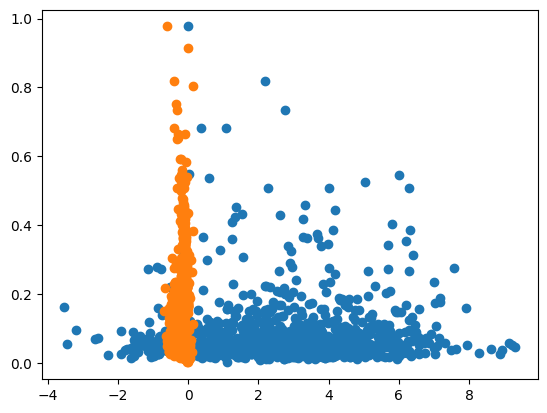

In [18]:
plt.scatter(footest[fooidx, :, 2], footest[fooidx, :, 5])
#plt.scatter(footest[7, :, 2], manga_sigmas[1000:2000, -1] )#+ np.random.normal(0, 0.01, (1000,)))
plt.scatter(data_target[:, 2], data_target[:, 5])

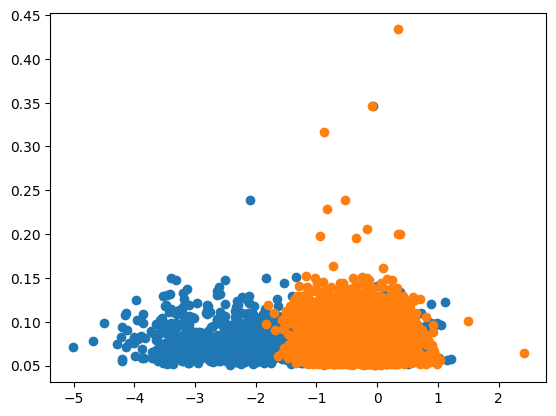

In [19]:
plt.scatter(footest[fooidx, :, 1], footest[fooidx, :, 4])
#plt.scatter(footest[7, :, 2], manga_sigmas[1000:2000, -1] )#+ np.random.normal(0, 0.01, (1000,)))
plt.scatter(data_target[:, 1], data_target[:, 4])

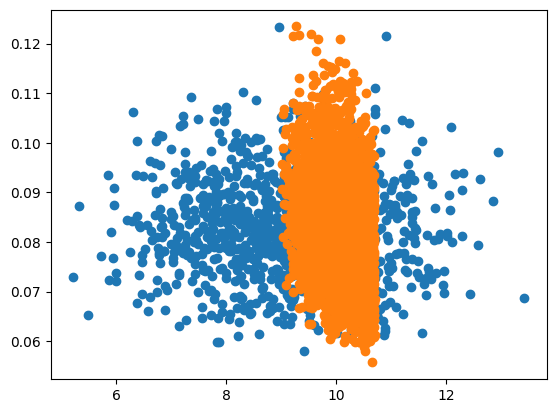

In [20]:
plt.scatter(footest[fooidx, :, 0], footest[fooidx, :, 3])
#plt.scatter(footest[7, :, 2], manga_sigmas[1000:2000, -1] )#+ np.random.normal(0, 0.01, (1000,)))
plt.scatter(data_target[:, 0], data_target[:, 3])

In [21]:
footest[..., -1].min(), footest[..., -2].min(), footest[..., -3].min()

(Array(0.00112557, dtype=float32),
 Array(0.05005, dtype=float32),
 Array(0.05568665, dtype=float32))

In [22]:
#train val split
num_features = 15 # this is for full dataset, but inputs will be truncated by noise_simulator

from sklearn.model_selection import train_test_split
data_, data_test, theta_, theta_test = train_test_split(data_full, theta_full, test_size=0.2, random_state=42)


batch_size = 200
n_train = data_.shape[0]

data_ = data_.reshape(-1, batch_size, n_d, num_features)
theta_ = theta_.reshape(-1, batch_size, n_params)

# reshape the test data into batches
data_test = data_test.reshape(-1, batch_size, n_d, num_features)
theta_test = theta_test.reshape(-1, batch_size, n_params)

In [23]:
data_.shape, theta_.shape, data_test.shape, theta_test.shape

((160, 200, 1000, 15), (160, 200, 4), (40, 200, 1000, 15), (40, 200, 4))

Now initialise your regression network. We're using a Fishnet network, which is a lot like a Deepset to operate on our permutation-invariant set of galaxies.

In [24]:
# initialise the regression (embedding) network

# FEEL FREE to play with the hidden channels here

# THE OUTPUTS HERE ARE GOING TO ALSO BE OUR INTRINISC SPREADS 

n_p_output = n_params + 3 # one sigma each for M, SFR, Zgas

key = jax.random.PRNGKey(0) # pseudo-random key for Jax network.
model = FishnetNetwork(
                        hidden_channels=[128,128,128],
                        n_p=n_p_output,
                        act=smooth_leaky,
                        
)
w = model.init(key, jnp.ones((n_d,num_features_input)))
mle, score, F = model.apply(w, jnp.ones((n_d,num_features_input)), jnp.ones((n_d, 1))) # this model outputs a prediction, an unweighted score vector, and a Fisher matrix.

In [25]:
mle

Array([ 0.36102074,  0.14476919,  0.07686985,  1.2045105 ,  1.5444745 ,
       -0.35828084,  1.1280761 ], dtype=float32)

In [26]:
import jax
jax.config.update("jax_debug_nans", True)

In [27]:
%xmode context

Exception reporting mode: Context


In [28]:
#@title training loop <font color='lightblue'>[run me]</font>

@jax.jit
def kl_loss(w, x_batched, theta_batched, mask_batched):

    def fn(x, theta, mask):
       mle,score,F = model.apply(w, x, mask)
       return mle, F

    mle, F = jax.vmap(fn)(x_batched, theta_batched, mask_batched)

    return -jnp.mean(-0.5 * jnp.einsum('ij,ij->i', (theta_batched - mle), \
                                             jnp.einsum('ijk,ik->ij', F, (theta_batched - mle))) \
                                                  + 0.5*jnp.log(jnp.linalg.det(F)), axis=0)


tx = optax.adam(learning_rate=1e-5)
opt_state = tx.init(w)
loss_grad_fn = jax.value_and_grad(kl_loss)


epochs = 1000

# this is a hack to make the for-loop training much faster in jax
def body_fun(i, inputs):
    w,loss_val, opt_state, _data, _theta, key = inputs
    x_samples = _data[i]
    y_samples = _theta[i]

    # apply noise simulator
    keys = jr.split(key, x_samples.shape[0])
    x_samples, masks, sigmas = jax.vmap(noise_simulator)(keys, x_samples)

    # concatenate the sigmas here
    y_samples = jnp.concatenate([y_samples, sigmas], -1)

    loss_val, grads = loss_grad_fn(w, x_samples, y_samples, masks)
    updates, opt_state = tx.update(grads, opt_state)
    w = optax.apply_updates(w, updates)

    return w, loss_val, opt_state, _data, _theta, key


def val_body_fun(i, inputs):
    w,loss_val, _data, _theta, key = inputs
    x_samples = _data[i]
    y_samples = _theta[i]

    # apply noise simulator
    keys = jr.split(key, x_samples.shape[0])
    x_samples, masks, sigmas = jax.vmap(noise_simulator)(keys, x_samples)

    # concatenate the sigmas here
    y_samples = jnp.concatenate([y_samples, sigmas], -1)

    loss_val, grads = loss_grad_fn(w, x_samples, y_samples, masks)

    return w, loss_val, _data, _theta, key


key = jax.random.PRNGKey(999)

losses = jnp.zeros(epochs)
val_losses = jnp.zeros(epochs)
loss_val = 0.
val_loss_value = 0.
lower = 0
upper = n_train // batch_size

pbar = tqdm(range(epochs), leave=True, position=0)
counter = 0

for j in pbar:
      key,rng = jax.random.split(key)

      # shuffle data every epoch
      randidx = jax.random.permutation(key, jnp.arange(theta_.reshape(-1, n_params).shape[0]), independent=True)
      _data = data_.reshape(-1, n_d, num_features)[randidx].reshape(batch_size, -1, n_d, num_features)
      _theta = theta_.reshape(-1, n_params)[randidx].reshape(batch_size, -1, n_params)

      #print(_data.shape)

      inits = (w, loss_val, opt_state, _data, _theta, key)

      w, loss_val, opt_state, _data, _theta, key = jax.lax.fori_loop(lower, upper, body_fun, inits)

      losses = losses.at[j].set(loss_val)


      # do validation set
      key,rng = jr.split(key)
      inits = (w, loss_val, data_test, theta_test, key)
      w, val_loss_value, data_test, theta_test, key = jax.lax.fori_loop(0, data_test.shape[0], val_body_fun, inits)
      val_losses = val_losses.at[j].set(val_loss_value)

      #val_losses.append(val_loss)
      pbar.set_description('epoch %d loss: %.5f  val loss: %.5f'%(j, loss_val, val_loss_value))

      counter += 1


epoch 550 loss: -2.94710  val loss: -3.76701:  55%|█████▌    | 551/1000 [1:16:49<1:02:36,  8.37s/it]


KeyboardInterrupt: 

In [31]:
save_obj(w, "fishnets_w_3input_9params_40k_14_10_predict_sigma_int_2")

(3.0, -13.0)

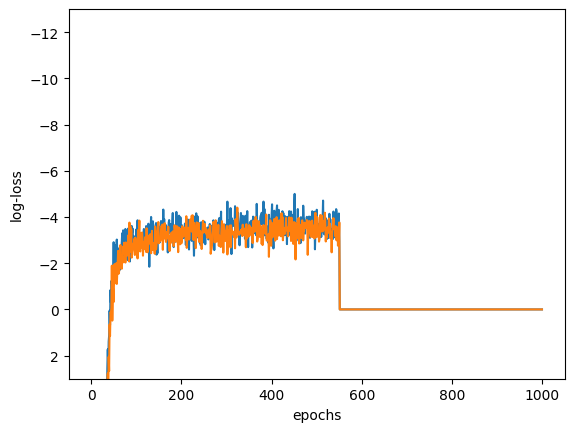

In [29]:
plt.plot(losses)
plt.plot(val_losses)
plt.xlabel("epochs")
plt.ylabel("log-loss")
plt.ylim(3, -13)

In [30]:
theta_test.shape, data_test.shape

((40, 200, 4), (40, 200, 1000, 15))

In [32]:
data_test = data_test.reshape(-1, n_d, num_features)
theta_test = theta_test.reshape(-1, n_params)

In [33]:
# load in new (massive) test set for the SBI inference
fname = '/data101/makinen/sapphire/jax_tng_lucas_100K_1000_9params_15features_20241107_batch1.npz'

def load_and_compress_data(key, fname, num_noise_realisations=1):
    data, theta = load_dataset(fname)

    print("data", data.shape)
    print("theta", theta.shape)

    theta_out = []
    
    mle_out = []
    F_out = []

    keys = jr.split(key, num_noise_realisations)

    for n in range(num_noise_realisations):
        key = keys[n]

        batchsize = 2000
        testsimulator = lambda k,d: noise_simulator(k,d, cut=None)
        data_test_in, masks_test, sigmas = jax.vmap(testsimulator)(jr.split(key, data.shape[0]), data)

        _app = lambda d, m: model.apply(w, d, m)

        
    
        mle_preds = []
        F_preds = []

        # loop over batches
        for i in tqdm(range(data.shape[0] // batchsize)):
            mle_pred,_,F_pred = jax.vmap(_app)(data_test_in.reshape(-1, n_d, num_features_input)[batchsize*i:(i+1)*batchsize], 
                                                       masks_test[batchsize*i:(i+1)*batchsize])
            mle_preds.append(mle_pred)
            F_preds.append(F_pred)
    
        mle_preds = jnp.concatenate(mle_preds, 0)
        F_preds = jnp.concatenate(F_preds, 0)

        # append sigmas to theta    
        theta_out.append(jnp.concatenate([theta, sigmas], -1))
        mle_out.append(mle_preds)
        F_out.append(F_preds)

    if num_noise_realisations > 1:
        return jnp.concatenate(mle_out, 0), jnp.concatenate(F_out, 0), jnp.concatenate(theta_out, 0)
    else:
        return mle_out[0], F_out[0], theta_out[0]


In [34]:
import gc
gc.collect()

3552

In [35]:
testkey = jr.PRNGKey(878)

In [36]:
mle_pred_test, F_pred_test, theta_test_true = load_and_compress_data(testkey, fname, num_noise_realisations=2)

data (10000, 1000, 15)
theta (10000, 4)
(3,)


100%|██████████| 5/5 [01:15<00:00, 15.10s/it]


In [43]:
mle_pred_test.shape, F_pred_test.shape, theta_test_true.shape

((20000, 7), (20000, 7, 7), (20000, 7))

In [44]:
 mle_pred_test

Array([[ 6.9158679e-01,  4.8080063e-01,  4.1520816e-01, ...,
         5.5782527e-01,  5.3601050e+00,  6.8828303e-01],
       [ 3.9871439e-01,  5.2565050e-01,  6.1148071e-01, ...,
         1.6188631e+00,  2.6307791e-01,  2.4446610e-01],
       [ 2.5287369e-01,  5.0579256e-01,  6.1767137e-01, ...,
        -3.4766391e-02,  2.3035796e-01,  2.8907692e-01],
       ...,
       [ 2.6209351e-01,  4.7470063e-01,  5.2017552e-01, ...,
         1.7102535e+00, -4.1588154e-03,  2.1473955e-01],
       [ 7.3538905e-01,  5.1217800e-01,  4.1521943e-01, ...,
         7.8885722e-01,  4.2019275e-01,  8.6700410e-02],
       [ 6.9595736e-01,  5.2817422e-01,  4.4068366e-01, ...,
        -7.8948840e-02,  5.4230798e-02,  1.7211972e-01]], dtype=float32)

### visualise regression network outputs
How well can the model produce point estimates for the parameters ?

In [45]:
n_params = 4 + 3

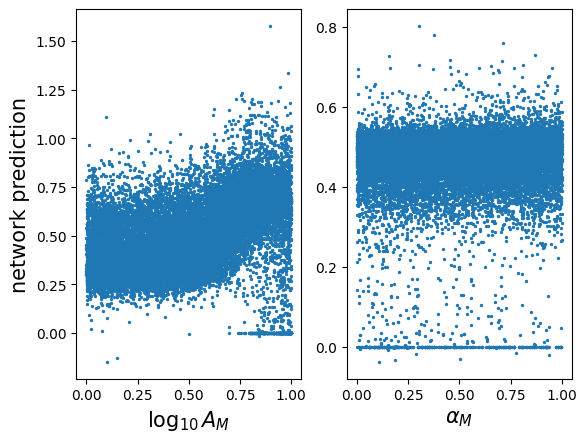

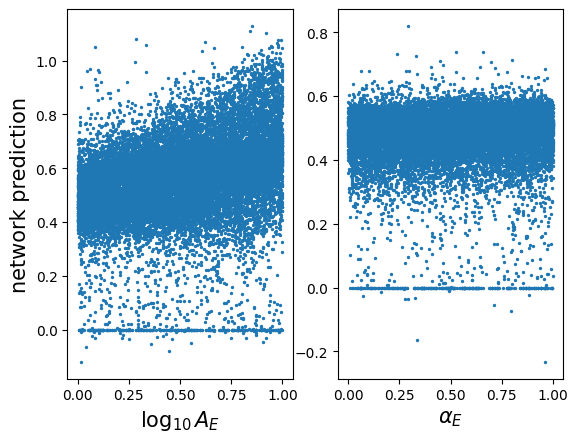

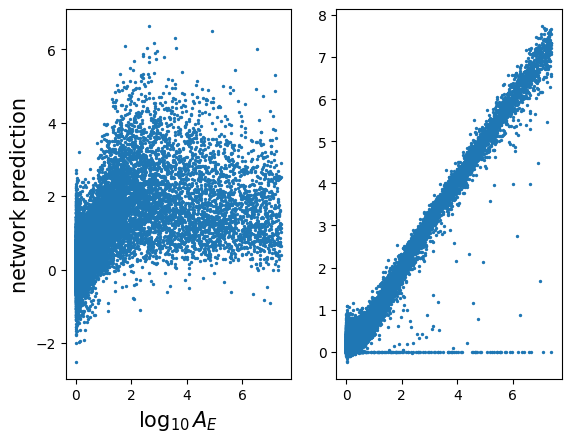

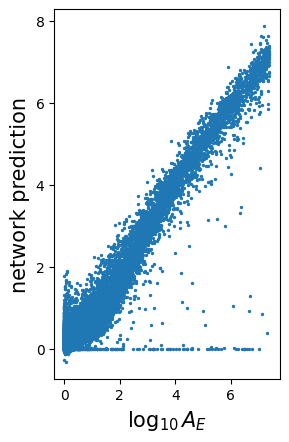

In [46]:
params = [r'$\log_{10} A_M$', r'$\alpha_M$', r'$\log_{10} A_E$', r'$\alpha_E$', r'$\sigma_m$',r'$\sigma_{\rm SFR}$', r'$\sigma_{\rm Zgas}$' ]

plt.subplot(121)
plt.scatter(theta_test_true.reshape(-1,n_params)[:, 0], mle_pred_test[:, 0], s=2)
plt.xlabel(params[0], fontsize=15)
plt.ylabel('network prediction', fontsize=15)

plt.subplot(122)
plt.scatter(theta_test_true.reshape(-1,n_params)[:, 1], mle_pred_test[:, 1], s=2)
plt.xlabel(params[1], fontsize=15)
plt.show()

plt.subplot(121)
plt.scatter(theta_test_true.reshape(-1,n_params)[:, 2], mle_pred_test[:, 2], s=2)
plt.ylabel('network prediction', fontsize=15)
plt.xlabel(params[2], fontsize=15)

plt.subplot(122)
plt.scatter(theta_test_true.reshape(-1,n_params)[:, 3], mle_pred_test[:, 3], s=2)

plt.xlabel(params[3], fontsize=15)
plt.show()

plt.subplot(121)
plt.scatter(theta_test_true.reshape(-1,n_params)[:, 4], mle_pred_test[:, 4], s=2)
plt.ylabel('network prediction', fontsize=15)
plt.xlabel(params[2], fontsize=15)

plt.subplot(122)
plt.scatter(theta_test_true.reshape(-1,n_params)[:, 5], mle_pred_test[:, 5], s=2)
plt.show()

plt.subplot(121)
plt.scatter(theta_test_true.reshape(-1,n_params)[:, 6], mle_pred_test[:, 6], s=2)
plt.ylabel('network prediction', fontsize=15)
plt.xlabel(params[2], fontsize=15)
plt.show()

## what have we learned so far ?

Let's take a moment to see what our network can do now.

We took *sets* of galaxy properties and compressed them down into **point estimates** $\hat{\theta}$ for the parameters of our simulator.


Here the galaxy energy loading factors ($\eta_E$) are extremely sensitive to halo and stellar mass properties, while mass loading factors $(\eta_M)$ are more difficult to constrain from mass features alone. Viraj explains it best:

>"The physical reason for this is that increasing $\eta_M$ leads to a higher circumgalactic medium (CGM) density and enhanced cooling of gas back into the galaxy without suppressing star formation, thus leading to a similar $M_* − M_{\rm vir}$ relation. Instead, increasing $\eta_E$ can heat the
CGM, prevent gas accretion, reduce star formation and alter the normalization and shape of the $M_* − M_{\rm vir}$  relation. " --Viraj Pandya




## visualise error bars

A bonus feature of the Fishnets network we used is that we also have access to the Fisher (inverse-covariance) matrix for the learned outputs. Here we'll take a look at the *point estimates* for the posterior density *without having to run a normalising flow* (yet).

In [47]:
theta_test_ = theta_test_true
mle_pred = mle_pred_test
F_pred = F_pred_test

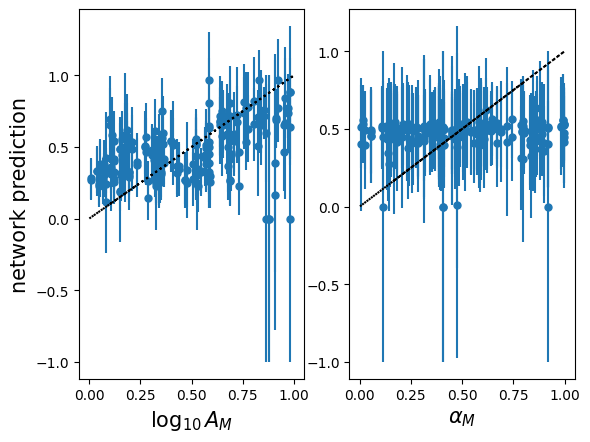

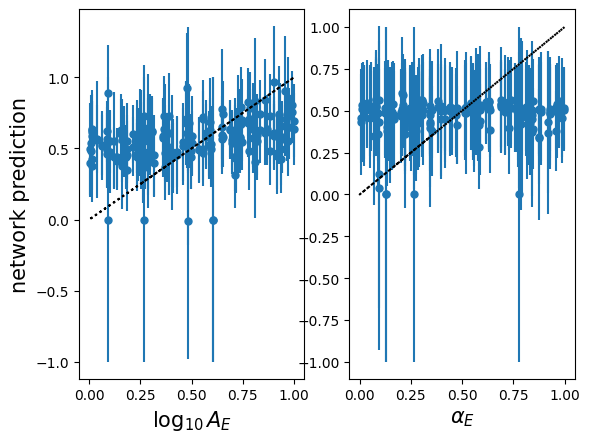

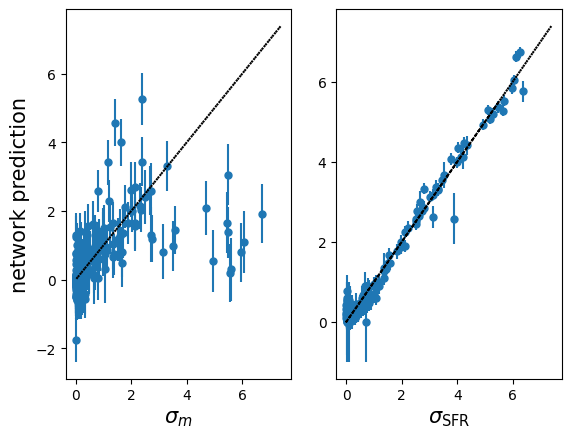

Text(0, 0.5, 'network prediction')

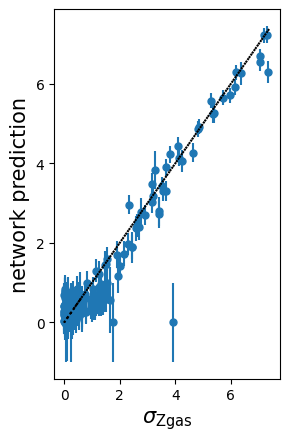

In [48]:
skip = 100

plt.subplot(121)
ind = 0
plt.errorbar(theta_test_.reshape(-1,n_params)[::skip, ind], mle_pred[::skip, ind],
             yerr=1./np.sqrt(F_pred[::skip, ind, ind]), fmt='o', markersize=5)

plt.plot(theta_test_.reshape(-1,n_params)[:, ind], theta_test_.reshape(-1,n_params)[:, ind], color='k', ls=':', zorder=10)
plt.xlabel(params[ind], fontsize=15)
plt.ylabel('network prediction', fontsize=15)


plt.subplot(122)
ind=1
plt.errorbar(theta_test_.reshape(-1,n_params)[::skip, ind], mle_pred[::skip, ind],
             yerr=1./(np.sqrt(F_pred[::skip, ind, ind])), fmt='o', markersize=5)
plt.plot(theta_test_.reshape(-1,n_params)[:, ind], theta_test_.reshape(-1,n_params)[:, ind], color='k', ls=':', zorder=10)

plt.xlabel(params[ind], fontsize=15)
plt.show()


plt.subplot(121)
ind=2
plt.errorbar(theta_test_.reshape(-1,n_params)[::skip, ind], mle_pred[::skip, ind],
             yerr=1./np.sqrt(F_pred[::skip, ind, ind]), fmt='o', markersize=5)
plt.plot(theta_test_.reshape(-1,n_params)[:, ind], theta_test_.reshape(-1,n_params)[:, ind], color='k', ls=':', zorder=10)

plt.xlabel(params[ind], fontsize=15)
plt.ylabel('network prediction', fontsize=15)

plt.subplot(122)
ind=3
plt.errorbar(theta_test_.reshape(-1,n_params)[::skip, ind], mle_pred[::skip, ind], yerr=1./np.sqrt(F_pred[::skip, ind, ind]), fmt='o', markersize=5)
plt.plot(theta_test_.reshape(-1,n_params)[:, ind], theta_test_.reshape(-1,n_params)[:, ind], color='k', ls=':', zorder=10)

plt.xlabel(params[ind], fontsize=15)
plt.show()


plt.subplot(121)
ind=4
plt.errorbar(theta_test_.reshape(-1,n_params)[::skip, ind], mle_pred[::skip, ind],
             yerr=1./np.sqrt(F_pred[::skip, ind, ind]), fmt='o', markersize=5)
plt.plot(theta_test_.reshape(-1,n_params)[:, ind], theta_test_.reshape(-1,n_params)[:, ind], color='k', ls=':', zorder=10)

plt.xlabel(params[ind], fontsize=15)
plt.ylabel('network prediction', fontsize=15)

plt.subplot(122)
ind=5
plt.errorbar(theta_test_.reshape(-1,n_params)[::skip, ind], mle_pred[::skip, ind], yerr=1./np.sqrt(F_pred[::skip, ind, ind]), fmt='o', markersize=5)
plt.plot(theta_test_.reshape(-1,n_params)[:, ind], theta_test_.reshape(-1,n_params)[:, ind], color='k', ls=':', zorder=10)

plt.xlabel(params[ind], fontsize=15)
plt.show()


plt.subplot(121)
ind=6
plt.errorbar(theta_test_.reshape(-1,n_params)[::skip, ind], mle_pred[::skip, ind],
             yerr=1./np.sqrt(F_pred[::skip, ind, ind]), fmt='o', markersize=5)
plt.plot(theta_test_.reshape(-1,n_params)[:, ind], theta_test_.reshape(-1,n_params)[:, ind], color='k', ls=':', zorder=10)

plt.xlabel(params[ind], fontsize=15)
plt.ylabel('network prediction', fontsize=15)


In [49]:
#@title we can also visualise the Fishers over parameter space (if you're so inclined)

from chainconsumer import ChainConsumer

params = [r'$\log_{10} A_M$', r'$\alpha_M$', r'$\log_{10} A_E$', r'$\alpha_E$']

cs = ChainConsumer()

for i in [3, 59, 300, 230, 1997, 42]:

    cs.add_covariance(theta_.reshape(-1, 4)[i], np.linalg.inv(F_pred[i]), parameters=params) #, color=corner_colors[0])

cs.configure(usetex=False)
cs.plotter.plot((7,7))

plt.show()

AttributeError: 'ChainConsumer' object has no attribute 'add_covariance'

Save all outputs before moving on to the posterior inference !

In [81]:
np.savez("fishnets_regression_outputs_3input_4param_100k_12_11_infer_sigma_int_batch1",
         mle_pred=mle_pred,
         theta_test=theta_test,
        )

In [96]:
(data_target[..., -1] > 10).sum()

Array(0, dtype=int32)

In [11]:
tread["e_OH_R23_cen"]

<MaskedColumn name='e_ZH_LW_Re_fit' dtype='float64' length=0>

In [234]:
# save the errors so that we can recycle them for training
df_final[['e_log_Mass', 'e_log_SFR_Ha', 'MW_Z_3ARCSEC_ERROR']]

e_log_Mass  e_log_SFR_Ha  MW_Z_3ARCSEC_ERROR
0       0.101380      0.092521            0.233493
1       0.089045      0.075433            0.193482
2       0.081200      0.059935            0.090084
3       0.084964      0.094216            0.127812
4       0.094235      0.074938            0.179843
...          ...           ...                 ...
3460    0.073180      0.069451            0.184946
3461    0.070108      0.061154            0.069888
3462    0.099937      0.079902            0.331272
3463    0.085210      0.055888            0.269813
3464    0.084699      0.073750            0.409811

[3427 rows x 3 columns]

In [51]:
# load in just the features we want
keyrand = jr.PRNGKey(88)

num_target = 460 # this is the mean of the n_gal that survive cuts in the test simulations.


randidx = jr.choice(keyrand, jnp.arange(df_final.shape[0]), shape=(num_target,), replace=False)

#data_target = jnp.array(df_final)[randidx] #[jnp.newaxis, ...]

data_target = np.array(df_final)[randidx]
data_target[..., 3:] = (data_target[..., 3:])
data_target = jnp.array(data_target)

_app = lambda d: model.apply(w, d, jnp.ones(((num_target, 1))))
mle_target,_,F_target = model.apply(w, data_target, jnp.ones((num_target,1)))

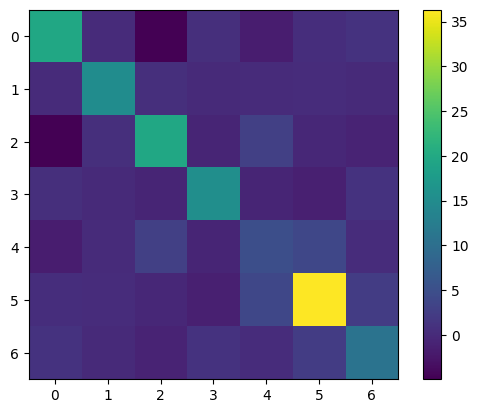

In [52]:
plt.imshow(F_target)
plt.colorbar()

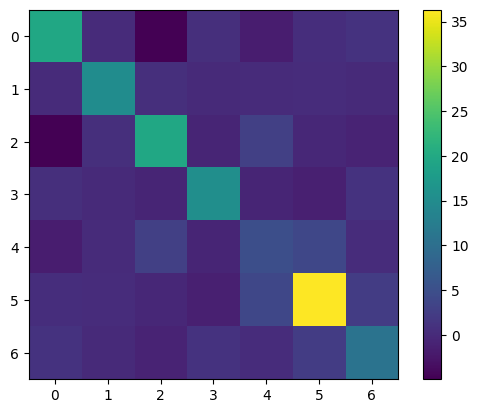

In [53]:
plt.imshow(F_target)
plt.colorbar()

In [54]:
data_target.shape


(460, 6)

In [55]:
mle_target

Array([ 0.4647704 ,  0.55516076,  0.4789041 ,  0.4462146 , -0.12273612,
        0.00242563,  0.05355487], dtype=float32)

Text(0, 0.5, '$\\hat{\\theta}_3$')

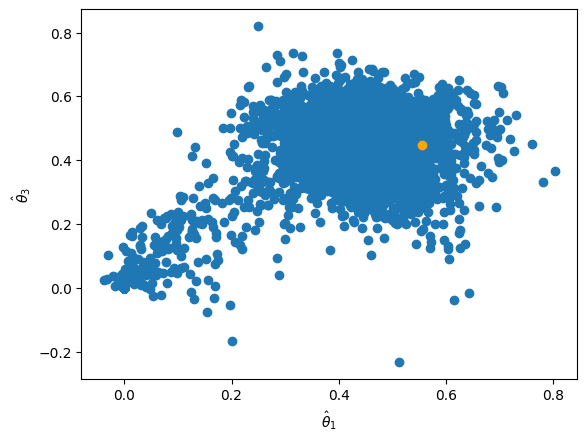

In [56]:
plt.scatter(mle_pred[:, 1], mle_pred[:, 3])
plt.scatter(mle_target[1], mle_target[3], c='orange', zorder=989999)
plt.xlabel(r"$\hat{\theta}_1$")
plt.ylabel(r"$\hat{\theta}_3$")

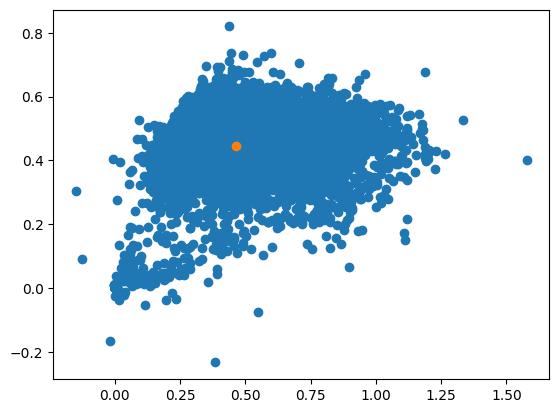

In [57]:
plt.scatter(mle_pred[:, 0], mle_pred[:, 3])
plt.scatter(mle_target[0], mle_target[3])

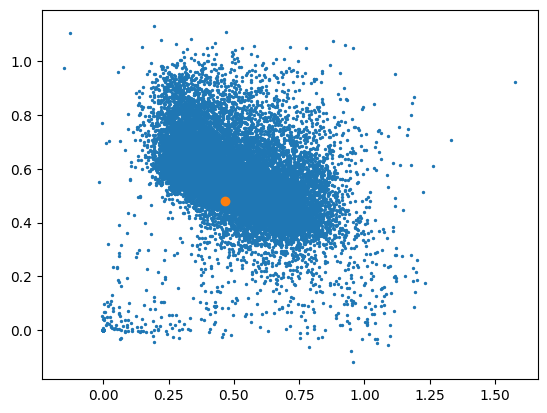

In [58]:
plt.scatter(mle_pred[:, 0], mle_pred[:, 2], s=2)
plt.scatter(mle_target[0], mle_target[2])

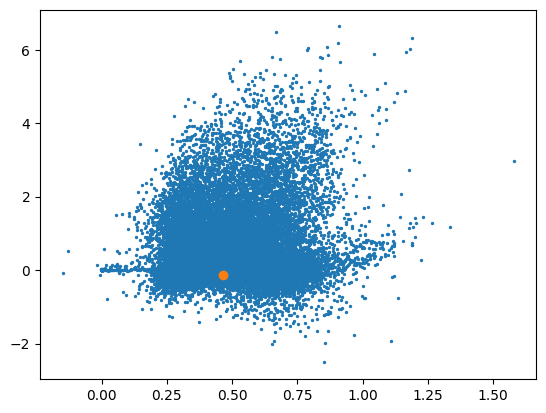

In [59]:
plt.scatter(mle_pred[:, 0], mle_pred[:, 4], s=2)
plt.scatter(mle_target[0], mle_target[4])

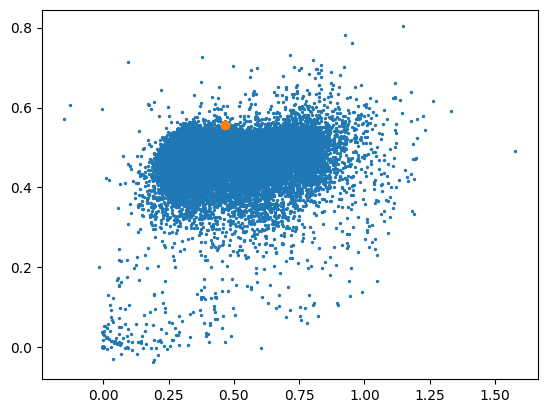

In [60]:
plt.scatter(mle_pred[:, 0], mle_pred[:, 1], s=2)
plt.scatter(mle_target[0], mle_target[1])

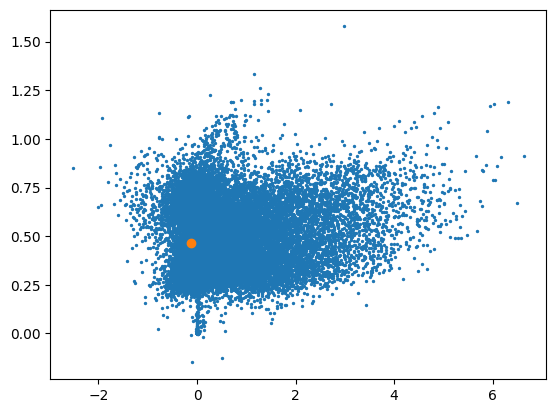

In [61]:
plt.scatter(mle_pred[:, 4], mle_pred[:, 0], s=2)
plt.scatter(mle_target[4], mle_target[0])

In [97]:
np.savez("target_compress_100k_9param_full_12_11_infer_sigma_int_batch1",
         mle_target = mle_target,
         F_target = F_target,
         data_target = np.array(data_target)
        )

# now look at ili posteriors with our regression summaries

Optionally install `ltu-ili` package here if you haven't done so already. We'll use the `.npz` file generated above for our summary-parameter pairs $(\hat{\theta}, \theta)$ to construct posteriors using a density estimator via the *Neural Posterior Estimation* (NPE) method.

In maths we're learning a model for
$$ p(\theta | \hat{\theta}) \propto p(\hat{\theta} | \theta) p(\theta) $$

where $\hat{\theta} = \text{net}(d; w)$ is the MLE point estimate from the Fishnets compression network we've optimised over the training set.

Note: installing `ltu-ili` here will reinstall pytorch and some other packages and will restart the session. This means you won't be able to use the trained model above (unless you save its weights).

In [137]:
mle_pred.shape

(20000, 9)

In [62]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import torch

import numpy as np
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


In [71]:
theta_test_.shape, mle_pred.shape

((20000, 7), (20000, 7))

In [72]:
theta_test_.shape

(20000, 7)

In [73]:
theta_test_.shape

(20000, 7)

In [113]:
#fname = "fishnets_regression_outputs_3input_1k_13_10"
#theta_test = np.load(fname)["theta_test"]
#mle_pred = np.load(fname)["mle_pred"]


from copy import deepcopy
_s = deepcopy(theta_test_[:, :4])  # samples.cpu().numpy()
#_t = deepcopy(mle_pred)

# unnormalize
_s = [scaler.inverse_transform(_s[i][np.newaxis, :]) for i in range(_s.shape[0])]
_s = np.array(_s).squeeze()

_s = np.concatenate([_s[:, :4], theta_test_[:, 4:]], -1)
#_t = scaler.inverse_transform(_t)

In [77]:
np.savez("manga_zgas_13_11_infer_sigma_int_batch1",
         mle_target=mle_target,
         theta=_s,
         mle_pred=mle_pred
        )

In [112]:
_s.min(axis=0), _s.max(axis=0), # _t.min(axis=0), _t.max(axis=0)

(array([-1.9998273, -1.9999783, -1.9999475, -1.9999862,        nan,
               nan,        nan], dtype=float32),
 array([ 1.9999902e+00, -2.3483701e-05, -6.9139337e-06, -8.7021808e-06,
                   nan,            nan,            nan], dtype=float32))

In [79]:
_s.shape

(20000, 7)

In [80]:
mle_pred_test.shape

(20000, 7)

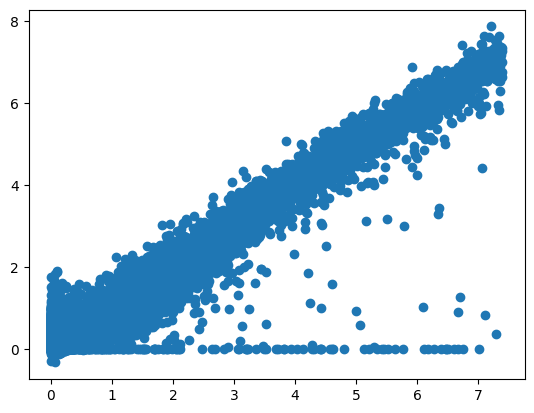

In [114]:
plt.scatter(_s[:, 6], mle_pred_test[:, 6])

In [115]:
np.log(_s[:, 4:].min())

-4.999734

In [117]:
from ili.embedding import FCN

activation = "SiLU"
n_hidden = [128, 128, 6]
embedding_network = FCN(n_hidden = n_hidden, act_fn = activation)


# transform to log-sigmas:
_s2 = deepcopy(_s)
_s2[:, 4:] = np.log10(_s2[:, 4:])

loader = NumpyLoader(x=np.array(mle_pred), theta=np.array(_s2))


# define a prior for the scaled thetas

prior = ili.utils.Uniform(low=[-2.0, -2.0, -2.0, -2.0, -5, -5, -5], high=[2, 0, 0, 0, 2, 2, 2], device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    #ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=70, num_transforms=5),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=80, num_transforms=6),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=100, num_transforms=6),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=80, num_transforms=7),
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=100, num_transforms=7),
    #ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=80, num_transforms=8),
    #ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=100, num_transforms=8),
    #ili.utils.load_nde_sbi(engine='NPE', model='nsf', hidden_features=70, num_transforms=6),
    #ili.utils.load_nde_sbi(engine='NPE', model='mdn', hidden_features=50, num_components=6)
]

# define training arguments
train_args = {
    'training_batch_size': 64,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=embedding_network,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [118]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
INFO:root:Training model 1 / 4.


 Training neural network. Epochs trained: 403

INFO:root:Training model 2 / 4.


 Training neural network. Epochs trained: 323404 epochs.

INFO:root:Training model 3 / 4.


 Training neural network. Epochs trained: 390324 epochs.

INFO:root:Training model 4 / 4.


 Training neural network. Epochs trained: 302391 epochs.

/home/makinen/venvs/epe/lib64/python3.11/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 3973.301045656204 seconds to train models.


 Neural network successfully converged after 303 epochs.

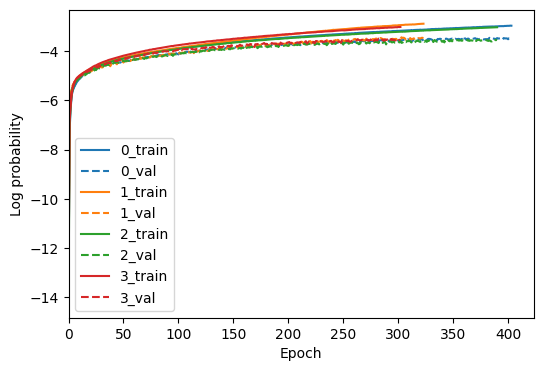

In [119]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [123]:
# choose a random input
seed_in = 345
np.random.seed(seed_in)
ind = np.random.randint(len(theta_test))

In [124]:
params = [r'$\log_{10} A_M$', r'$\alpha_M$', r'$\log_{10} A_E$', r'$\alpha_E$', r'$\log \sigma_m$',r'$\log \sigma_{\rm SFR}$', r'$\log \sigma_{\rm Zgas}$' ]


Drawing 1304 posterior samples:   0%|          | 0/1304 [00:00<?, ?it/s]

Drawing 1289 posterior samples:   0%|          | 0/1289 [00:00<?, ?it/s]

Drawing 1222 posterior samples:   0%|          | 0/1222 [00:00<?, ?it/s]

Drawing 1185 posterior samples:   0%|          | 0/1185 [00:00<?, ?it/s]

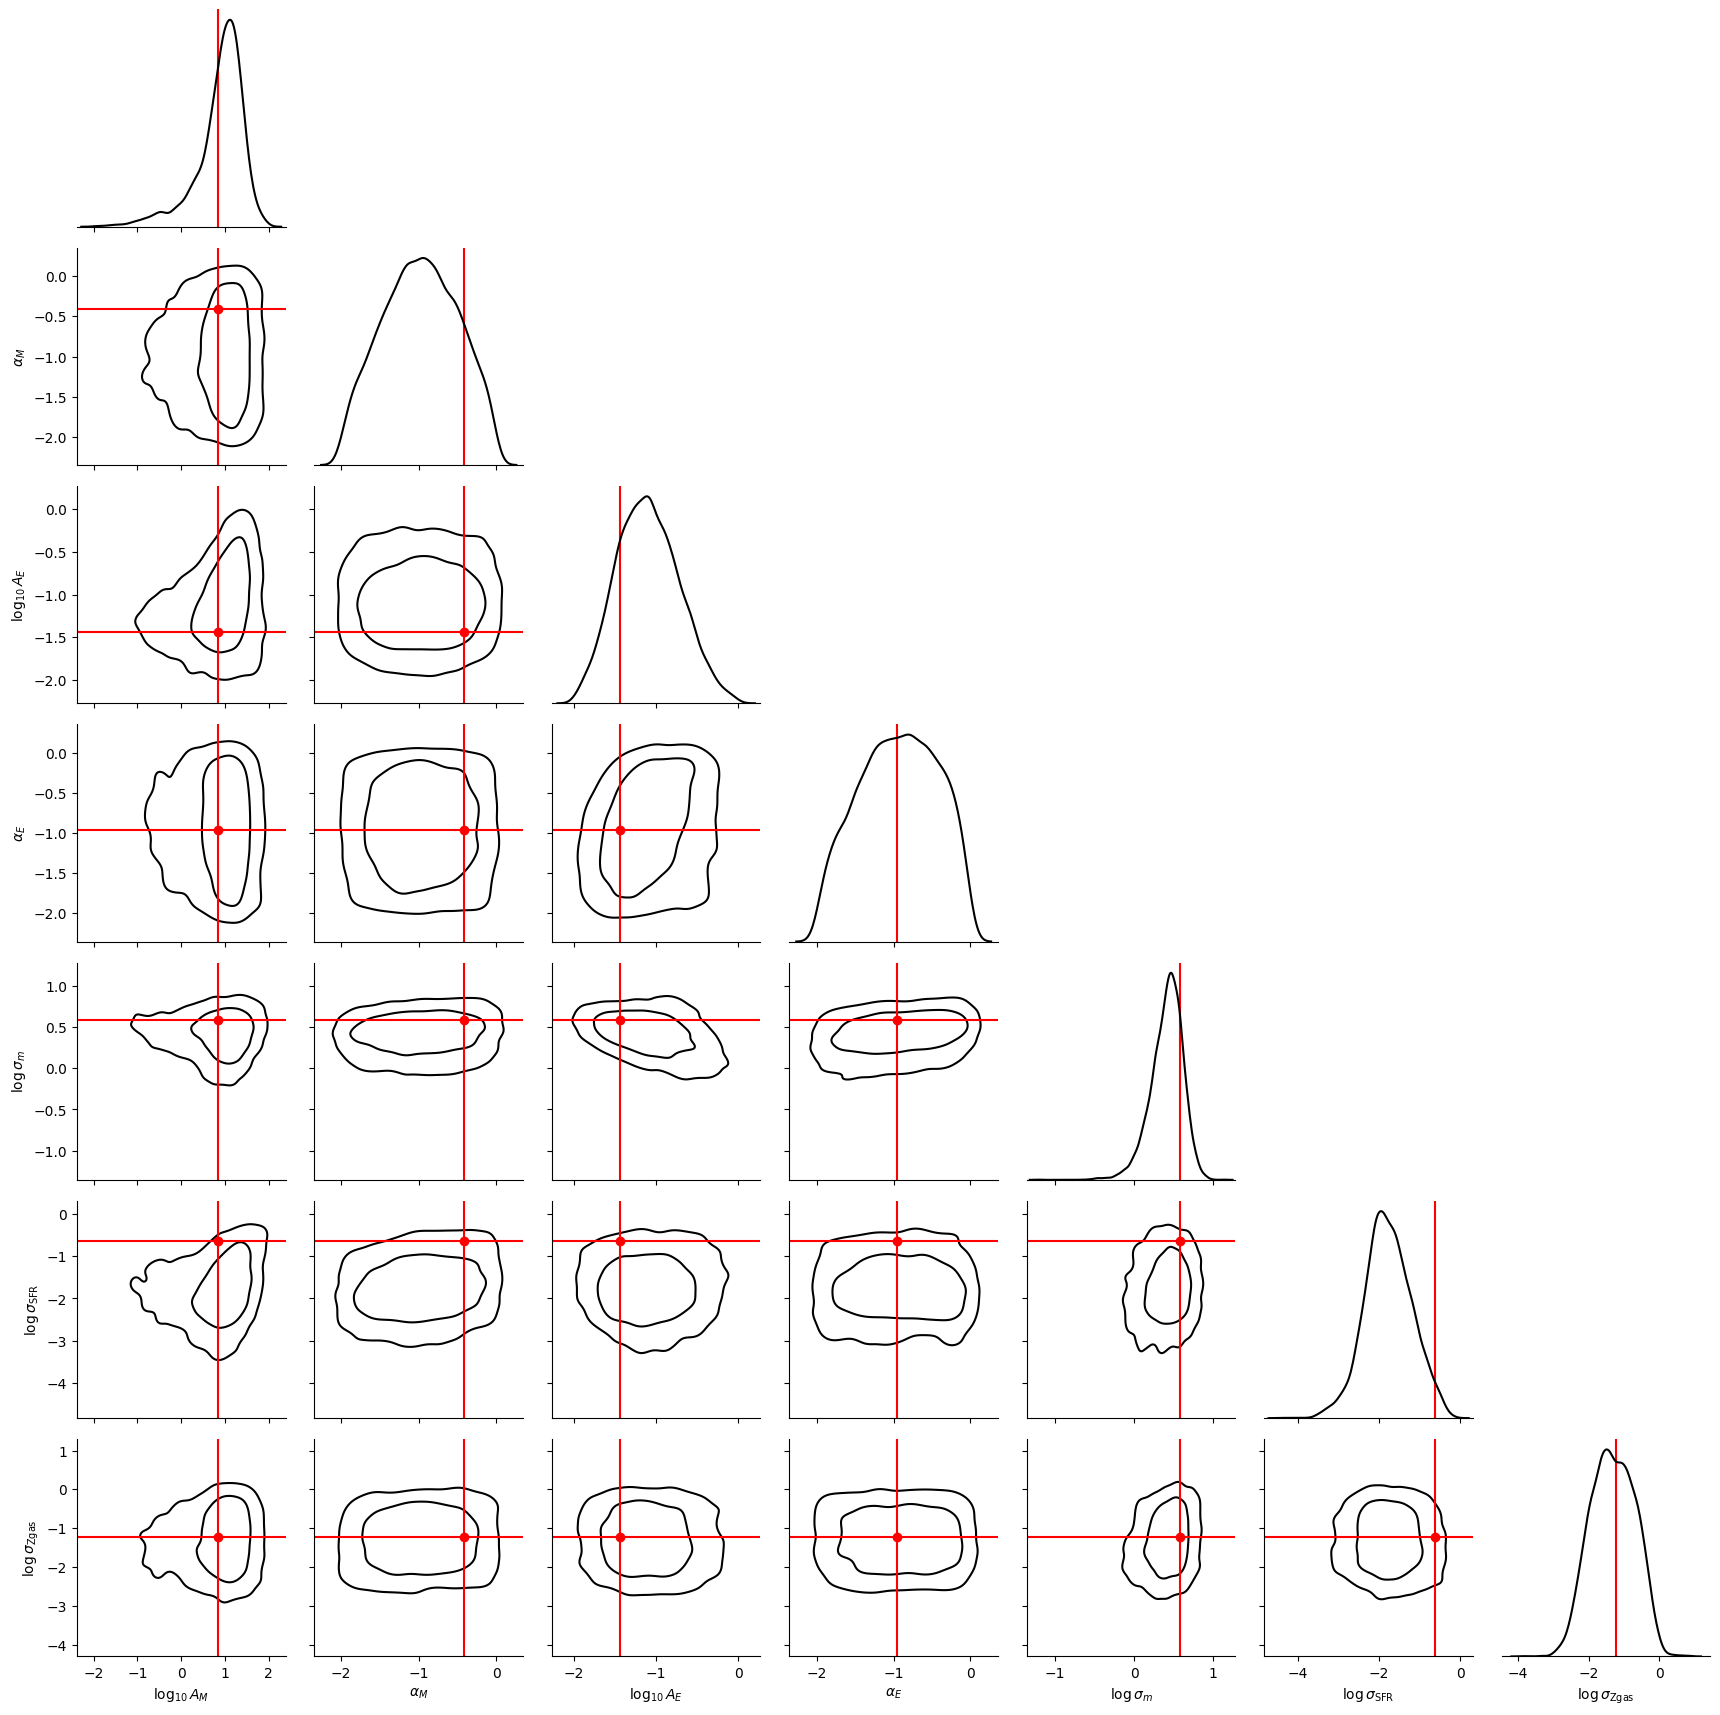

In [126]:
# use ltu-ili's built-in validation metrics to plot the posterior for this set of galaxies !

#params = [r'$\log_{10} A_M$', r'$\alpha_M$', r'$\log_{10} A_E$', r'$\alpha_E$']

labels = params

metric = PlotSinglePosterior(
    num_samples=5000, sample_method='direct',
    labels=labels
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = np.array(mle_pred[ind]), theta_fid=np.array(_s2[ind])
)
#plt.savefig("galaxy_posterior.png", dpi=500)

In [102]:
mle_target.shape, mle_pred.shape

((7,), (20000, 7))

Drawing 1260 posterior samples:   0%|          | 0/1260 [00:00<?, ?it/s]

Drawing 1403 posterior samples:   0%|          | 0/1403 [00:00<?, ?it/s]

Drawing 1155 posterior samples:   0%|          | 0/1155 [00:00<?, ?it/s]

Drawing 1182 posterior samples:   0%|          | 0/1182 [00:00<?, ?it/s]

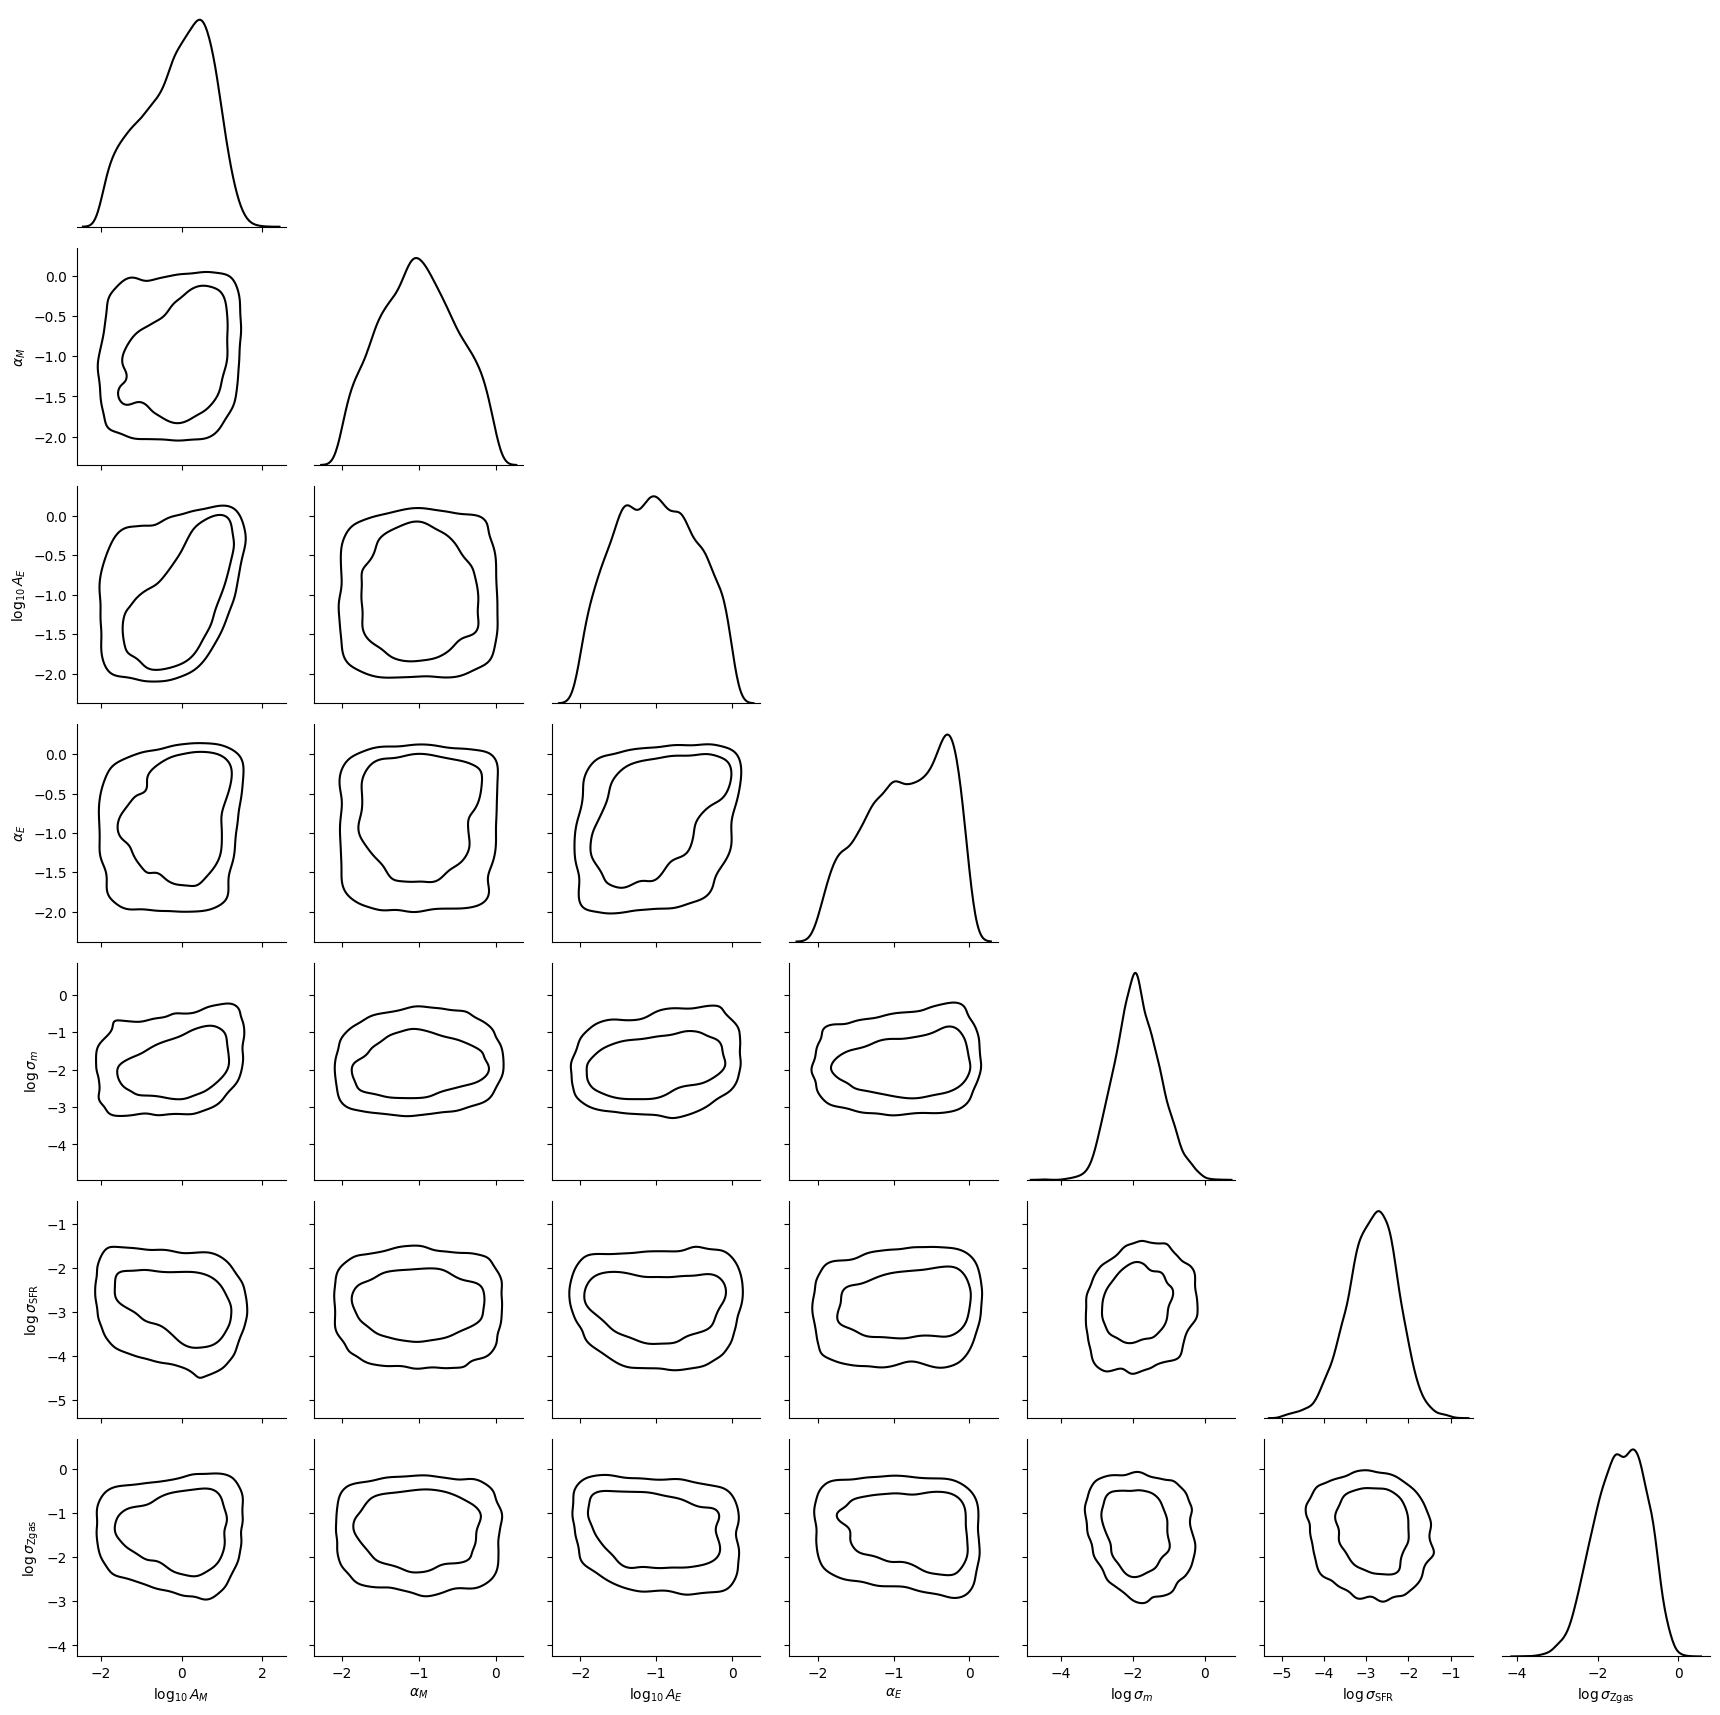

In [127]:

metric = PlotSinglePosterior(
    num_samples=5000, sample_method='direct',
    labels=params
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = np.array(mle_target),
)

In [128]:
chains_target = posterior_ensemble.sample(sample_shape=(100000,), x=torch.tensor(np.array(mle_target)).to(device))

Drawing 25598 posterior samples:   0%|          | 0/25598 [00:00<?, ?it/s]

Drawing 26182 posterior samples:   0%|          | 0/26182 [00:00<?, ?it/s]

Drawing 23585 posterior samples:   0%|          | 0/23585 [00:00<?, ?it/s]

Drawing 24635 posterior samples:   0%|          | 0/24635 [00:00<?, ?it/s]

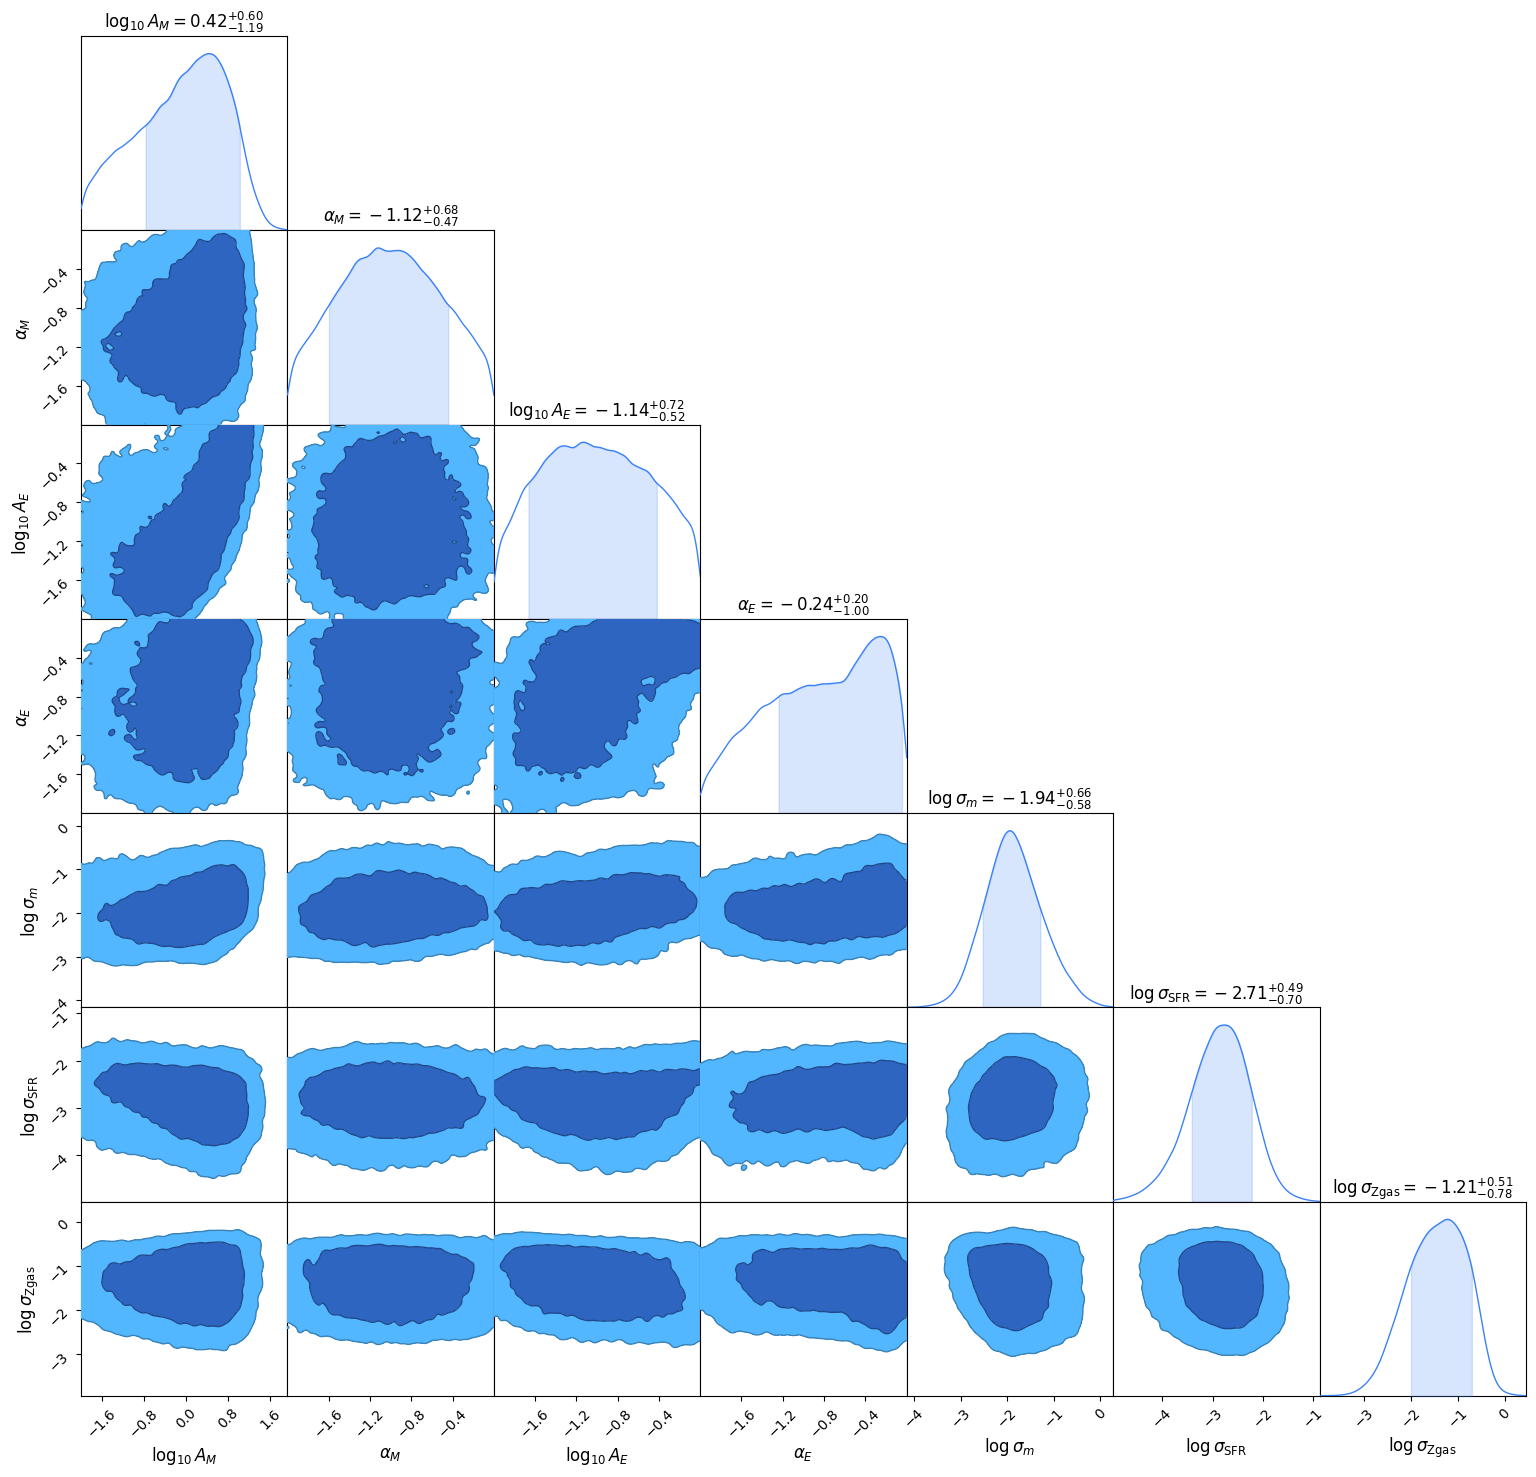

In [129]:
from chainconsumer import Chain, ChainConsumer, make_sample
import pandas as pd



df = pd.DataFrame((chains_target.cpu().numpy()), columns=params)


c = ChainConsumer()
c.add_chain(Chain(samples=df, name="target data N=500",))


fig = c.plotter.plot()
plt.show()

In [130]:
np.savez("target_compress_13_11_9param_full_4models_sigmaints_2",
         mle_target = mle_target,
         F_target = F_target,
         data_target = np.array(data_target),
         chains_target = chains_target.cpu().numpy()
        )

In [240]:
import 

IndependentUniform(Uniform(low: torch.Size([4]), high: torch.Size([4])), 1)

### do a bootstrap inference over random samples of 200 gals

In [134]:
# load in just the features we want
keyrand = jr.PRNGKey(60)

num_draws = 15
num_galaxies = 441

num_galaxies = 500
keys = jr.split(keyrand, num_draws)

chains_to_plot = []

for i,k in enumerate(keys):

    randidx = jr.choice(k, jnp.arange(df_final.shape[0]), shape=(num_galaxies,), replace=False)
    data_target = jnp.array(df_final[['log_Mass','log_SFR_Ha','log_Zgas', 'e_log_Mass', 'e_log_SFR_Ha', 'e_OH_R23_cen' ]])[randidx] #[jnp.newaxis, ...]

    _app = lambda d: model.apply(w, d, jnp.ones(((num_galaxies, 1))))
    mle_target,_,F_target = model.apply(w, data_target, jnp.ones((num_galaxies,1)))

    chains_target = posterior_ensemble.sample(sample_shape=(10000,), x=torch.tensor(np.array(mle_target)).to(device))
    chains_to_plot.append(chains_target.cpu().numpy())

Drawing 2593 posterior samples:   0%|          | 0/2593 [00:00<?, ?it/s]

Drawing 2547 posterior samples:   0%|          | 0/2547 [00:00<?, ?it/s]

Drawing 2384 posterior samples:   0%|          | 0/2384 [00:00<?, ?it/s]

Drawing 2476 posterior samples:   0%|          | 0/2476 [00:00<?, ?it/s]

Drawing 2527 posterior samples:   0%|          | 0/2527 [00:00<?, ?it/s]

Drawing 2596 posterior samples:   0%|          | 0/2596 [00:00<?, ?it/s]

Drawing 2424 posterior samples:   0%|          | 0/2424 [00:00<?, ?it/s]

Drawing 2453 posterior samples:   0%|          | 0/2453 [00:00<?, ?it/s]

Drawing 2579 posterior samples:   0%|          | 0/2579 [00:00<?, ?it/s]

Drawing 2645 posterior samples:   0%|          | 0/2645 [00:00<?, ?it/s]

Drawing 2326 posterior samples:   0%|          | 0/2326 [00:00<?, ?it/s]

Drawing 2450 posterior samples:   0%|          | 0/2450 [00:00<?, ?it/s]

Drawing 2606 posterior samples:   0%|          | 0/2606 [00:00<?, ?it/s]

Drawing 2675 posterior samples:   0%|          | 0/2675 [00:00<?, ?it/s]

Drawing 2352 posterior samples:   0%|          | 0/2352 [00:00<?, ?it/s]

Drawing 2367 posterior samples:   0%|          | 0/2367 [00:00<?, ?it/s]

Drawing 2540 posterior samples:   0%|          | 0/2540 [00:00<?, ?it/s]

Drawing 2611 posterior samples:   0%|          | 0/2611 [00:00<?, ?it/s]

Drawing 2374 posterior samples:   0%|          | 0/2374 [00:00<?, ?it/s]

Drawing 2475 posterior samples:   0%|          | 0/2475 [00:00<?, ?it/s]

Drawing 2533 posterior samples:   0%|          | 0/2533 [00:00<?, ?it/s]

Drawing 2569 posterior samples:   0%|          | 0/2569 [00:00<?, ?it/s]

Drawing 2369 posterior samples:   0%|          | 0/2369 [00:00<?, ?it/s]

Drawing 2529 posterior samples:   0%|          | 0/2529 [00:00<?, ?it/s]

Drawing 2549 posterior samples:   0%|          | 0/2549 [00:00<?, ?it/s]

Drawing 2562 posterior samples:   0%|          | 0/2562 [00:00<?, ?it/s]

Drawing 2394 posterior samples:   0%|          | 0/2394 [00:00<?, ?it/s]

Drawing 2495 posterior samples:   0%|          | 0/2495 [00:00<?, ?it/s]

Drawing 2469 posterior samples:   0%|          | 0/2469 [00:00<?, ?it/s]

Drawing 2608 posterior samples:   0%|          | 0/2608 [00:00<?, ?it/s]

Drawing 2446 posterior samples:   0%|          | 0/2446 [00:00<?, ?it/s]

Drawing 2477 posterior samples:   0%|          | 0/2477 [00:00<?, ?it/s]

Drawing 2552 posterior samples:   0%|          | 0/2552 [00:00<?, ?it/s]

Drawing 2582 posterior samples:   0%|          | 0/2582 [00:00<?, ?it/s]

Drawing 2429 posterior samples:   0%|          | 0/2429 [00:00<?, ?it/s]

Drawing 2437 posterior samples:   0%|          | 0/2437 [00:00<?, ?it/s]

Drawing 2623 posterior samples:   0%|          | 0/2623 [00:00<?, ?it/s]

Drawing 2539 posterior samples:   0%|          | 0/2539 [00:00<?, ?it/s]

Drawing 2414 posterior samples:   0%|          | 0/2414 [00:00<?, ?it/s]

Drawing 2424 posterior samples:   0%|          | 0/2424 [00:00<?, ?it/s]

Drawing 2520 posterior samples:   0%|          | 0/2520 [00:00<?, ?it/s]

Drawing 2585 posterior samples:   0%|          | 0/2585 [00:00<?, ?it/s]

Drawing 2400 posterior samples:   0%|          | 0/2400 [00:00<?, ?it/s]

Drawing 2495 posterior samples:   0%|          | 0/2495 [00:00<?, ?it/s]

Drawing 2498 posterior samples:   0%|          | 0/2498 [00:00<?, ?it/s]

Drawing 2634 posterior samples:   0%|          | 0/2634 [00:00<?, ?it/s]

Drawing 2394 posterior samples:   0%|          | 0/2394 [00:00<?, ?it/s]

Drawing 2474 posterior samples:   0%|          | 0/2474 [00:00<?, ?it/s]

Drawing 2513 posterior samples:   0%|          | 0/2513 [00:00<?, ?it/s]

Drawing 2591 posterior samples:   0%|          | 0/2591 [00:00<?, ?it/s]

Drawing 2410 posterior samples:   0%|          | 0/2410 [00:00<?, ?it/s]

Drawing 2486 posterior samples:   0%|          | 0/2486 [00:00<?, ?it/s]

Drawing 2494 posterior samples:   0%|          | 0/2494 [00:00<?, ?it/s]

Drawing 2608 posterior samples:   0%|          | 0/2608 [00:00<?, ?it/s]

Drawing 2374 posterior samples:   0%|          | 0/2374 [00:00<?, ?it/s]

Drawing 2524 posterior samples:   0%|          | 0/2524 [00:00<?, ?it/s]

Drawing 2542 posterior samples:   0%|          | 0/2542 [00:00<?, ?it/s]

Drawing 2549 posterior samples:   0%|          | 0/2549 [00:00<?, ?it/s]

Drawing 2391 posterior samples:   0%|          | 0/2391 [00:00<?, ?it/s]

Drawing 2518 posterior samples:   0%|          | 0/2518 [00:00<?, ?it/s]

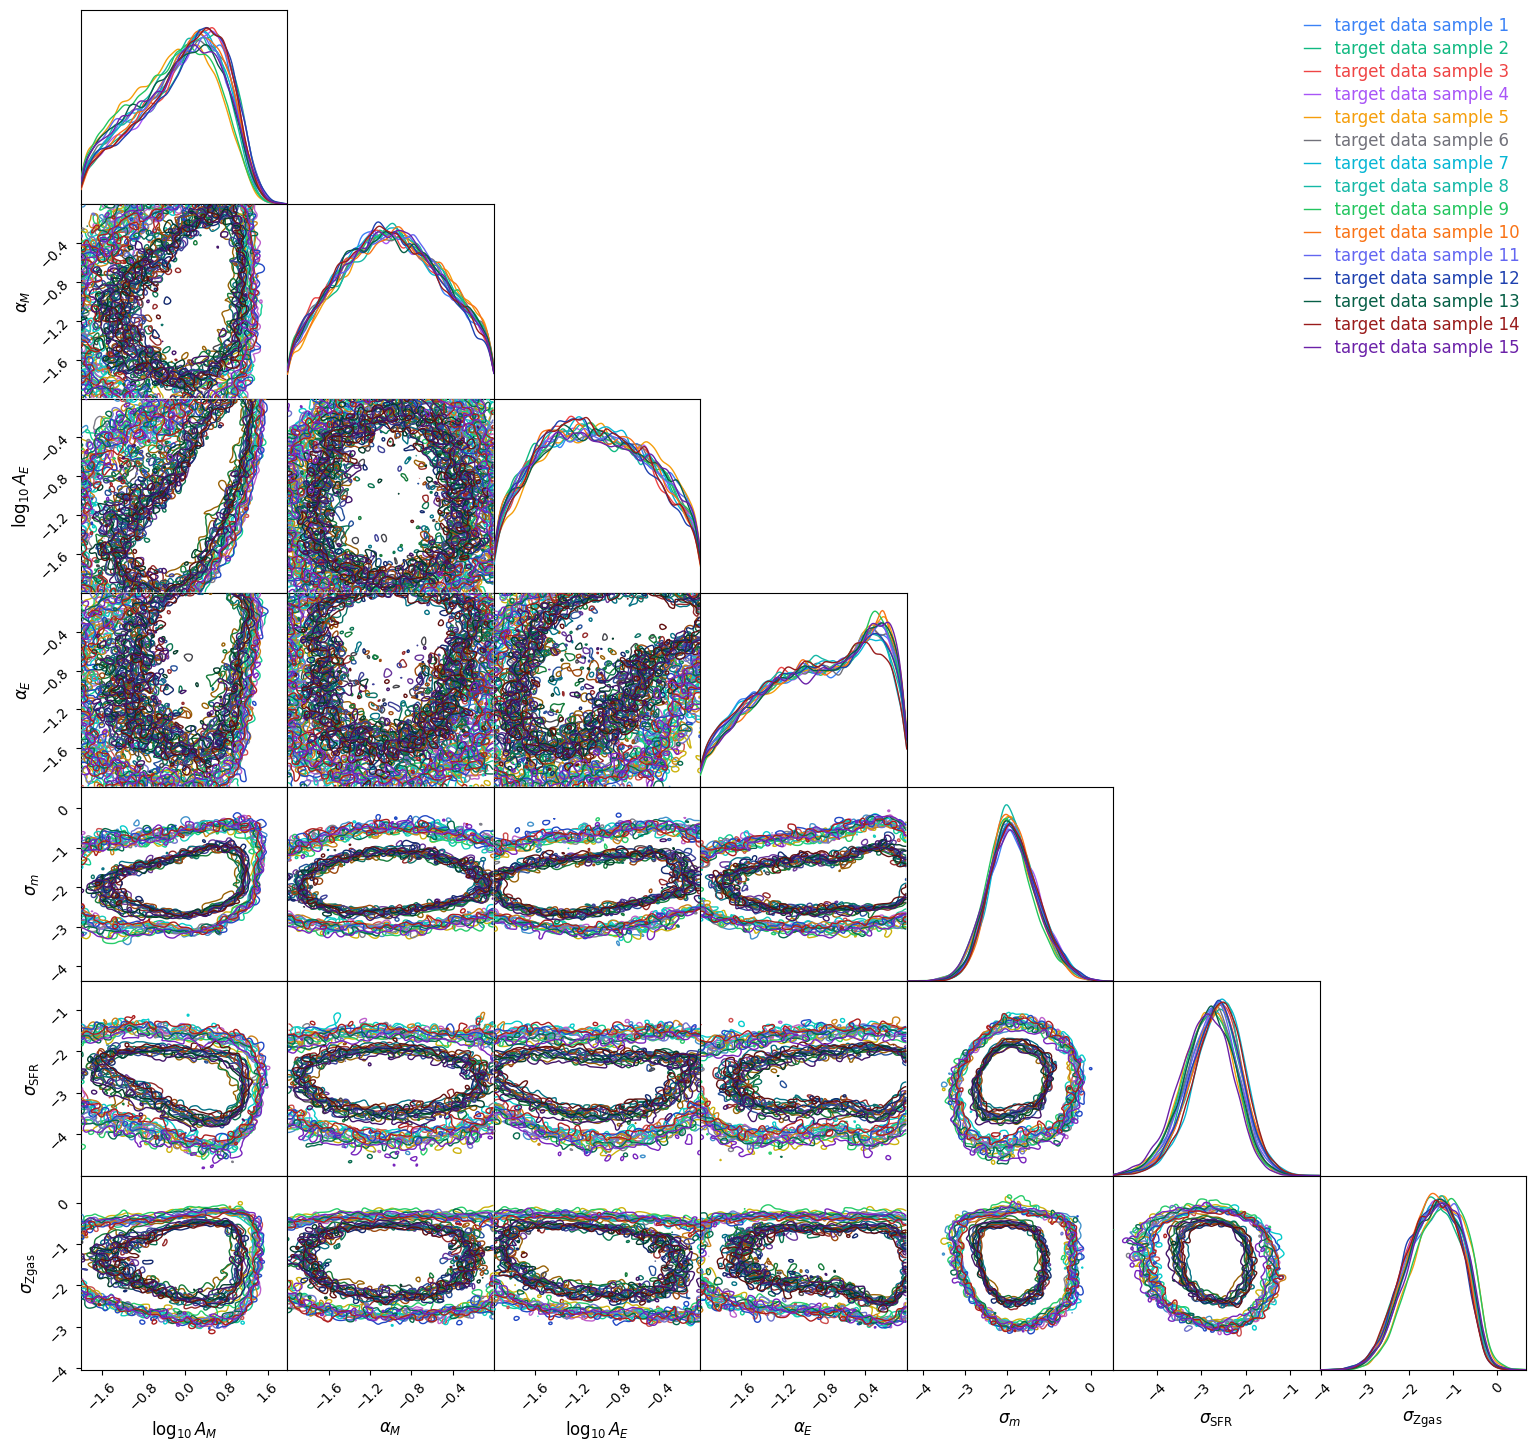

In [135]:
from chainconsumer import Chain, ChainConsumer, make_sample
import pandas as pd

params = [r'$\log_{10} A_M$', r'$\alpha_M$', r'$\log_{10} A_E$', r'$\alpha_E$', r'$\sigma_m$',r'$\sigma_{\rm SFR}$', r'$\sigma_{\rm Zgas}$' ]

c = ChainConsumer()

for i,chain in enumerate(chains_to_plot):

    df = pd.DataFrame(chain, columns=params)
    c.add_chain(Chain(samples=df, name="target data sample %d"%(i+1),))


fig = c.plotter.plot()
plt.show()

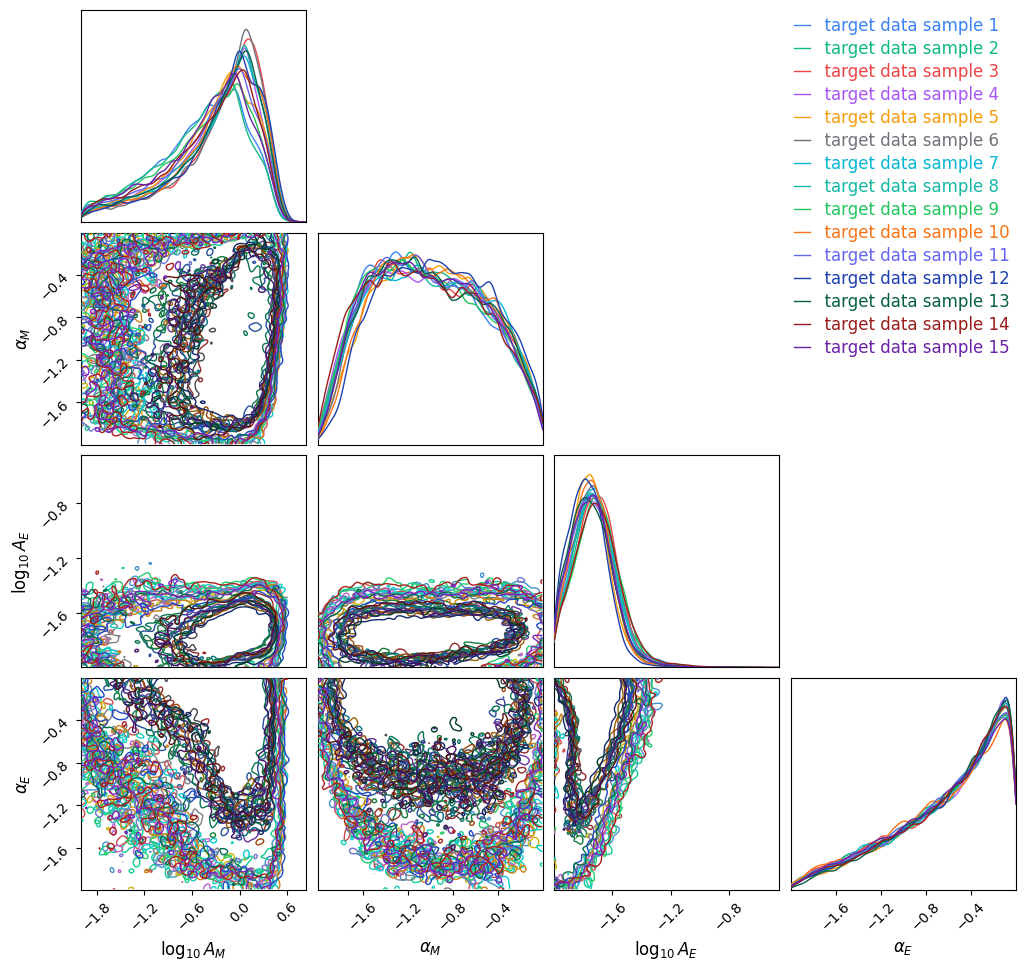

In [63]:
from chainconsumer import Chain, ChainConsumer, make_sample
import pandas as pd

c = ChainConsumer()

for i,chain in enumerate(chains_to_plot):

    df = pd.DataFrame(chain, columns=params)
    c.add_chain(Chain(samples=df, name="target data sample %d"%(i+1),))


fig = c.plotter.plot()
plt.show()

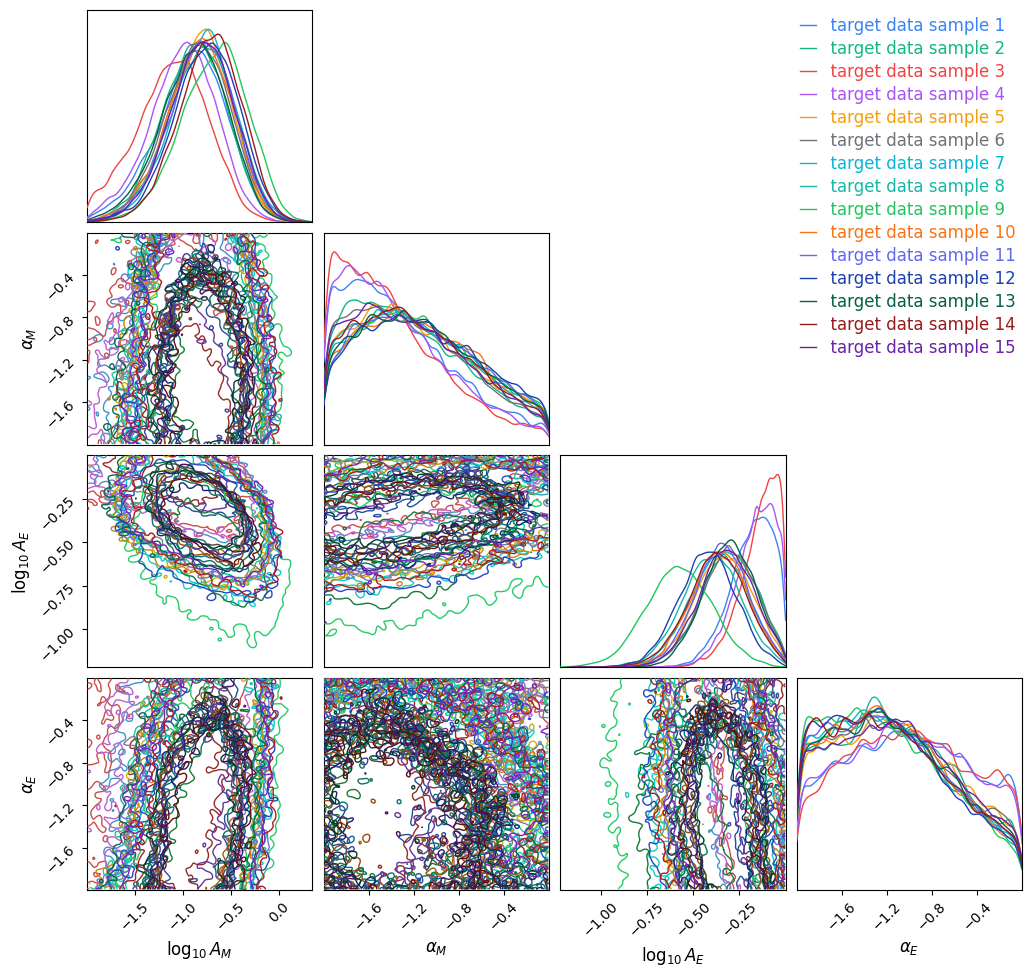

In [384]:
from chainconsumer import Chain, ChainConsumer, make_sample
import pandas as pd

params = [r'$\log_{10} A_M$', r'$\alpha_M$', r'$\log_{10} A_E$', r'$\alpha_E$']

c = ChainConsumer()

for i,chain in enumerate(chains_to_plot):

    df = pd.DataFrame(chain, columns=params)
    c.add_chain(Chain(samples=df, name="target data sample %d"%(i+1),))


fig = c.plotter.plot()
plt.show()

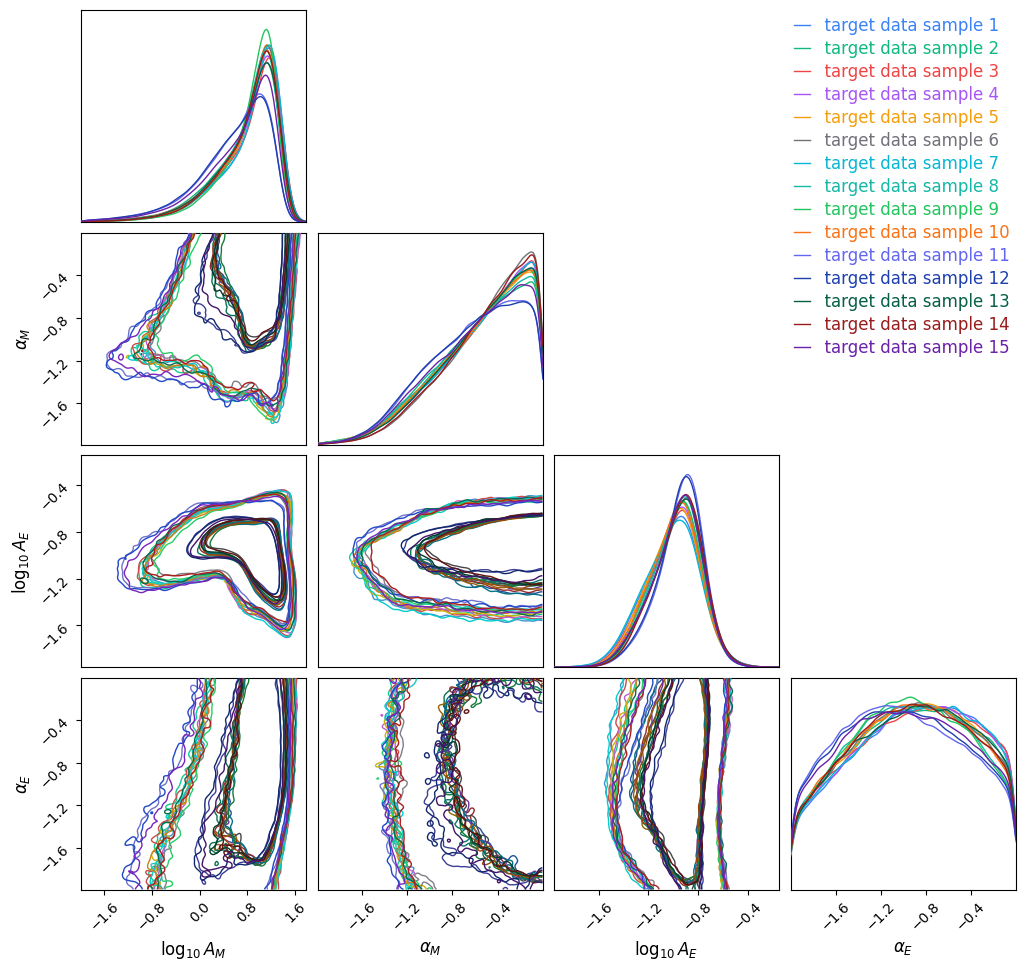

In [320]:
from chainconsumer import Chain, ChainConsumer, make_sample
import pandas as pd

params = [r'$\log_{10} A_M$', r'$\alpha_M$', r'$\log_{10} A_E$', r'$\alpha_E$']

c = ChainConsumer()

for i,chain in enumerate(chains_to_plot):

    df = pd.DataFrame(chain, columns=params)
    c.add_chain(Chain(samples=df, name="target data sample %d"%(i+1),))


fig = c.plotter.plot()
plt.show()

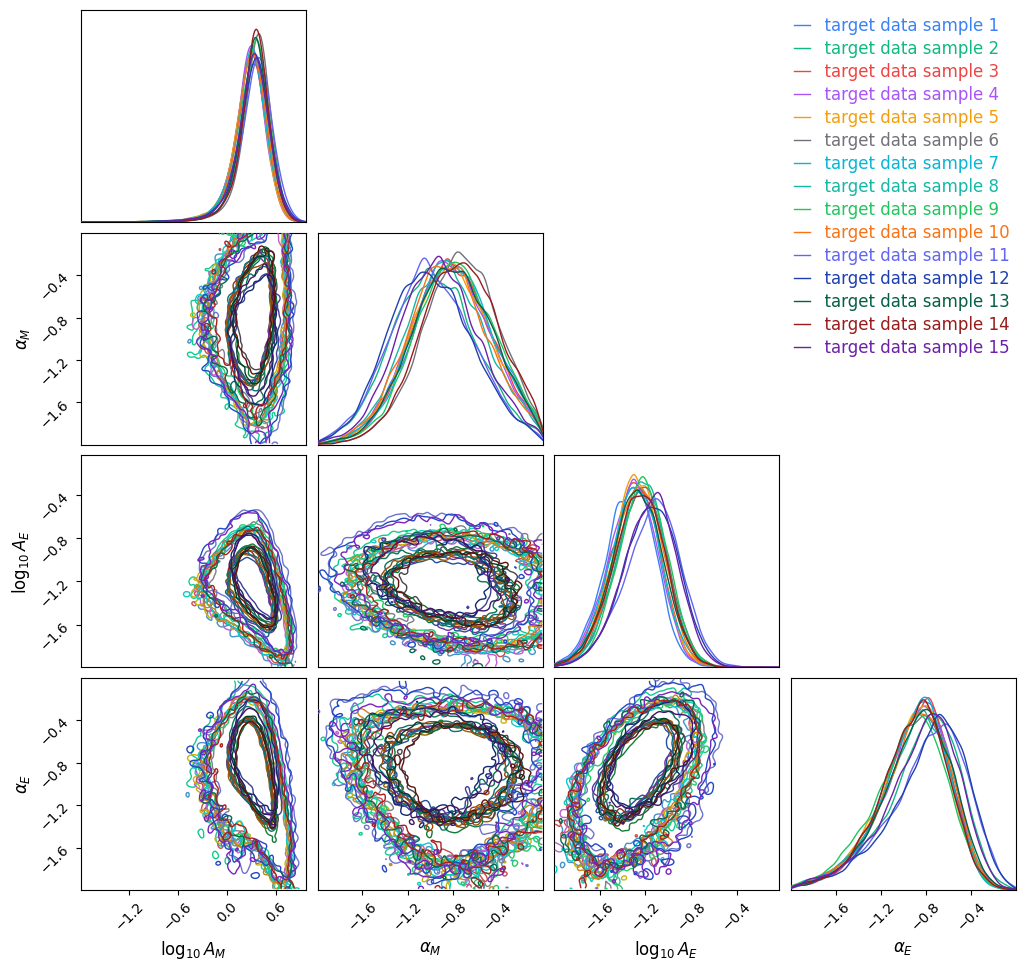

In [235]:
from chainconsumer import Chain, ChainConsumer, make_sample
import pandas as pd

params = [r'$\log_{10} A_M$', r'$\alpha_M$', r'$\log_{10} A_E$', r'$\alpha_E$']

c = ChainConsumer()

for i,chain in enumerate(chains_to_plot):

    df = pd.DataFrame(chain, columns=params)
    c.add_chain(Chain(samples=df, name="target data sample %d"%(i+1),))


fig = c.plotter.plot()
plt.show()

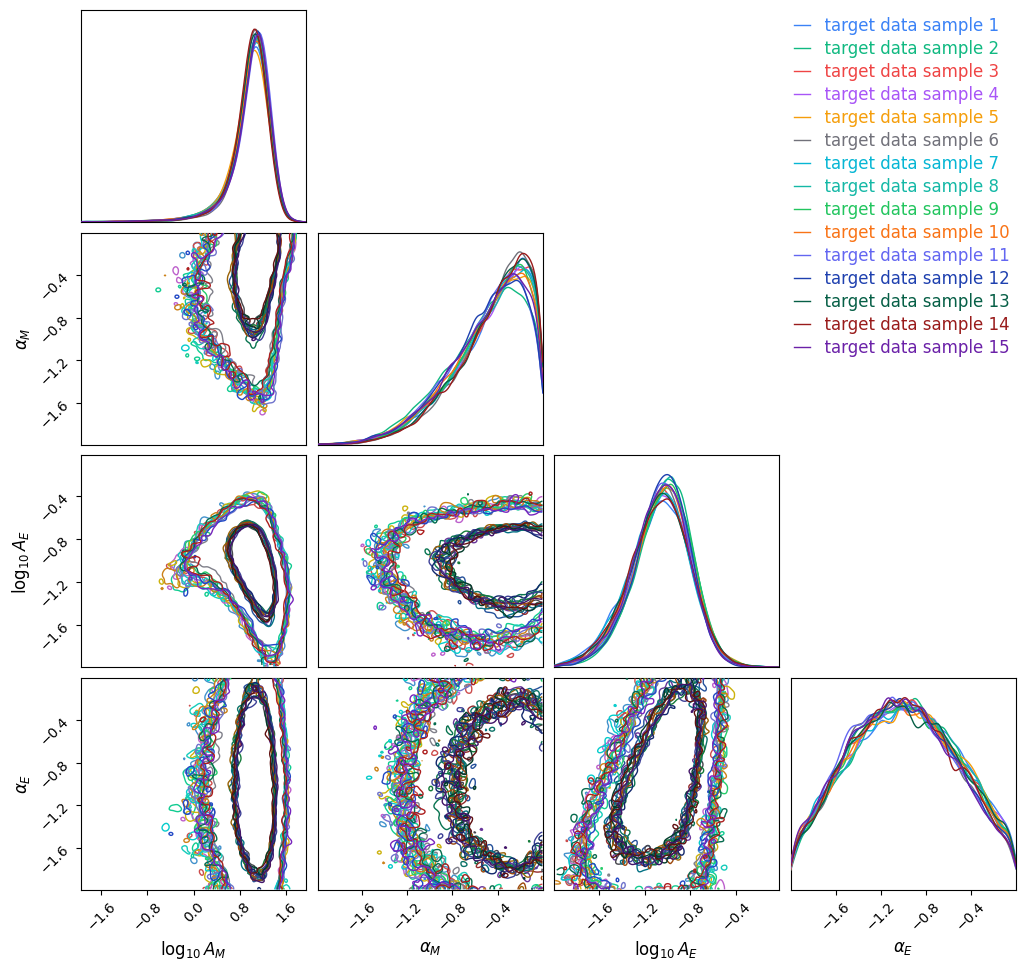

In [207]:
from chainconsumer import Chain, ChainConsumer, make_sample
import pandas as pd

params = [r'$\log_{10} A_M$', r'$\alpha_M$', r'$\log_{10} A_E$', r'$\alpha_E$']

c = ChainConsumer()

for i,chain in enumerate(chains_to_plot):

    df = pd.DataFrame(chain, columns=params)
    c.add_chain(Chain(samples=df, name="target data sample %d"%(i+1),))


fig = c.plotter.plot()
plt.show()

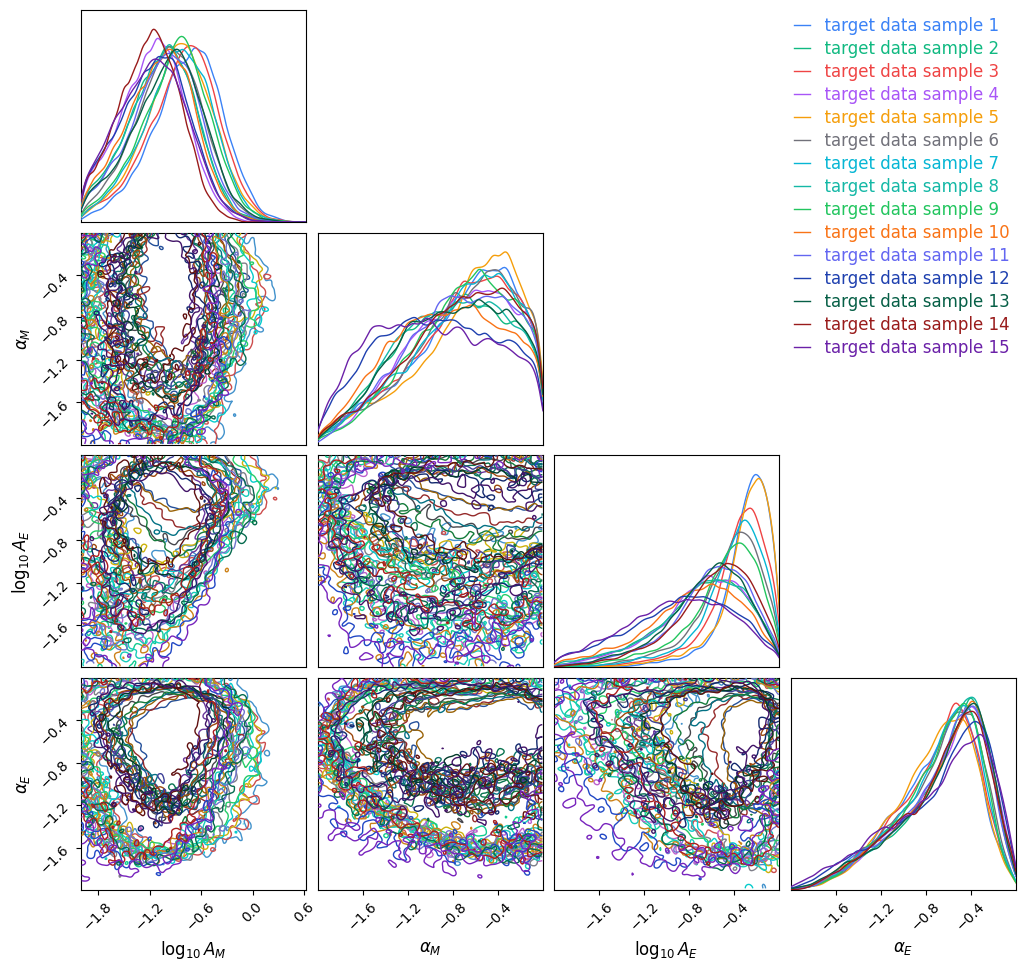

In [83]:
from chainconsumer import Chain, ChainConsumer, make_sample
import pandas as pd

params = [r'$\log_{10} A_M$', r'$\alpha_M$', r'$\log_{10} A_E$', r'$\alpha_E$']

c = ChainConsumer()

for i,chain in enumerate(chains_to_plot):

    df = pd.DataFrame(chain, columns=params)
    c.add_chain(Chain(samples=df, name="target data sample %d"%(i+1),))


fig = c.plotter.plot()
plt.show()

In [88]:
np.concatenate(chains_to_plot).shape

(150000, 4)

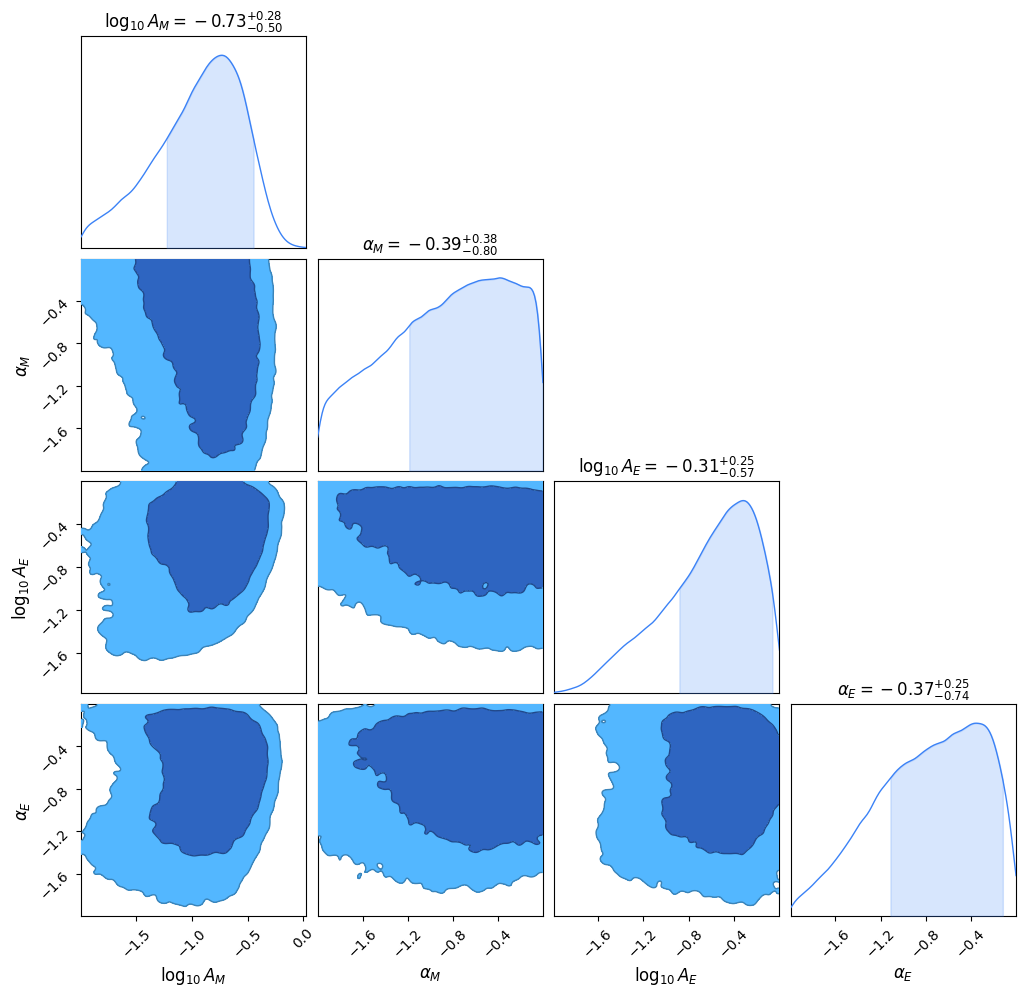

In [126]:
from chainconsumer import Chain, ChainConsumer, make_sample
import pandas as pd

params = [r'$\log_{10} A_M$', r'$\alpha_M$', r'$\log_{10} A_E$', r'$\alpha_E$']


df = pd.DataFrame(np.concatenate(chains_to_plot)[::1], columns=params)


c = ChainConsumer()
c.add_chain(Chain(samples=df, name="target data N=500",))


fig = c.plotter.plot()
plt.show()

In [133]:
np.savez("manga_target_compress_13_11_9params_full_fourmodels_sigmaints",
         mle_target = mle_target,
         F_target = F_target,
         data_target = np.array(data_target),
         #chains_target = chains_target.cpu().numpy()
         chains_multi_target=np.array(chains_to_plot)
        )